In [1]:
from pyspark.sql import SparkSession
spark = ( 
    SparkSession
    .builder
    .config("spark.master", "local[*]")
    .config("spark.driver.memory", "120g")
    .config("spark.driver.maxResultSize", "0")
    .enableHiveSupport()
    .getOrCreate()
)

In [2]:
import socket
port = spark.sparkContext.uiWebUrl.split(":")[-1]
hostname = socket.gethostname()
print(f"https://{hostname}/jupyter/user/stevengs/proxy/{port}/jobs/")

https://epyc.astro.washington.edu/jupyter/user/stevengs/proxy/4046/jobs/


In [3]:
import axs
from fit_utils import plot_fit_result
import matplotlib.pyplot as plt
import numpy as np

In [4]:
catalog = axs.AxsCatalog(spark)
skew_normal_fits = catalog.load("6_4_20_stevengs_skew_normal_fits_r_band")

In [5]:
from models import skew_normal

Row(sum_square_error=247.902099609375, reduced_sum_square_error=1.073169231414795)


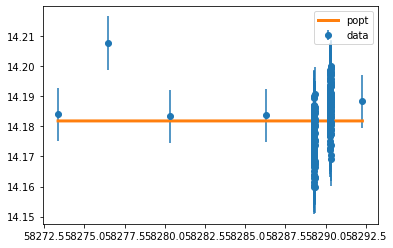

In [6]:
_lc = skew_normal_fits.head(1)[0]
x = _lc['dip_window_r']['x']
y = _lc['dip_window_r']['y']
yerr = _lc['dip_window_r']['yerr']
fit = _lc['fit_r']
plot_fit_result(
    x, y, yerr, 
    fit, skew_normal
)
print(_lc['model_error_in_dip_r'])

In [7]:
chi_sq = skew_normal_fits.select(skew_normal_fits['model_error_in_dip_r']).collect()

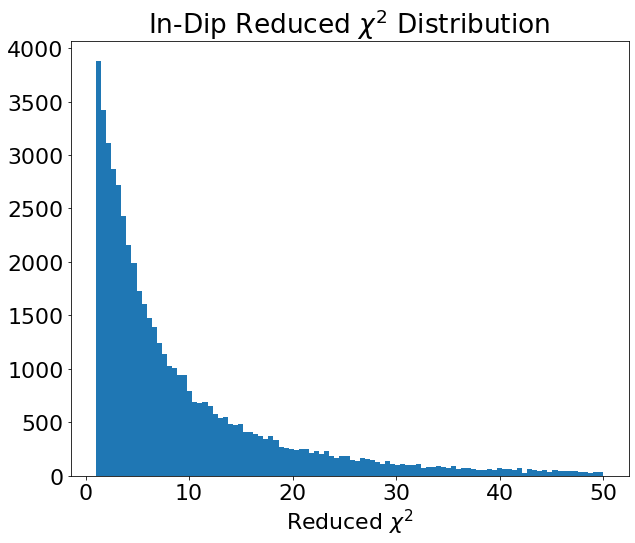

In [8]:
plt.rc("figure", figsize=[10, 8])
plt.rc("font", size=22)
plt.hist([_['model_error_in_dip_r']['reduced_sum_square_error'] for _ in chi_sq], bins=100, range=(1, 50))
plt.title("In-Dip Reduced $\chi^2$ Distribution")
plt.xlabel("Reduced $\chi^2$")
plt.show()

In [9]:
skew = skew_normal_fits.select(skew_normal_fits['fit_r']['popt'][0]).collect()

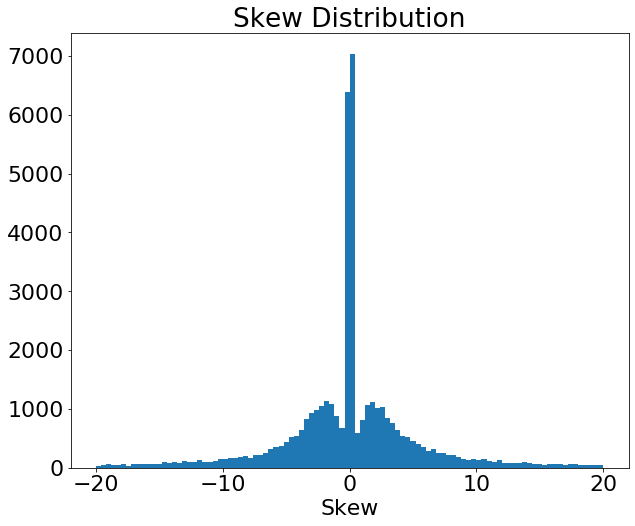

In [10]:
plt.hist([_['fit_r.popt[0]'] for _ in skew], bins=100, range=(-20, 20))
plt.title("Skew Distribution")
plt.xlabel("Skew")
plt.show()

# Cut data using in-dip $\chi^2$

In [11]:
fits_to_show = skew_normal_fits.where(
    (skew_normal_fits['model_error_in_dip_r.reduced_sum_square_error'] < 20) &  
    (
        (skew_normal_fits['fit_r.popt'][0] > 2) | (skew_normal_fits['fit_r.popt'][0] < -2)
    )
).sort(
    skew_normal_fits['model_error_in_dip_r.reduced_sum_square_error'],
    ascending=True
)

In [12]:
fits_to_show_in_memory = fits_to_show.collect()


    id               = 126552657304058543
    dip.significance = 7.089189529418945
    fit_r.skew       = 39.91177749633789
    


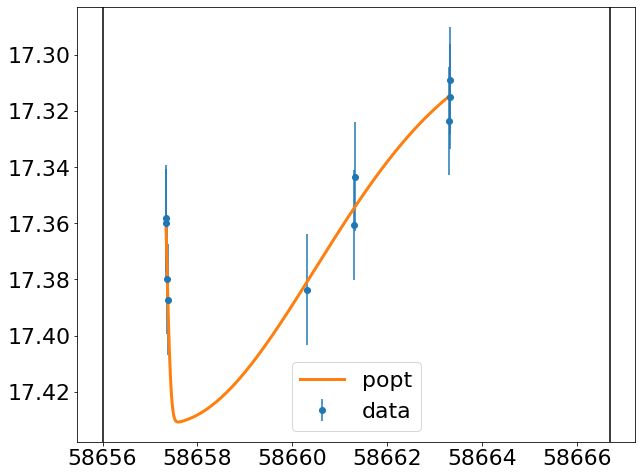


    id               = 137572907861138182
    dip.significance = 7.388136863708496
    fit_r.skew       = -4494.25244140625
    


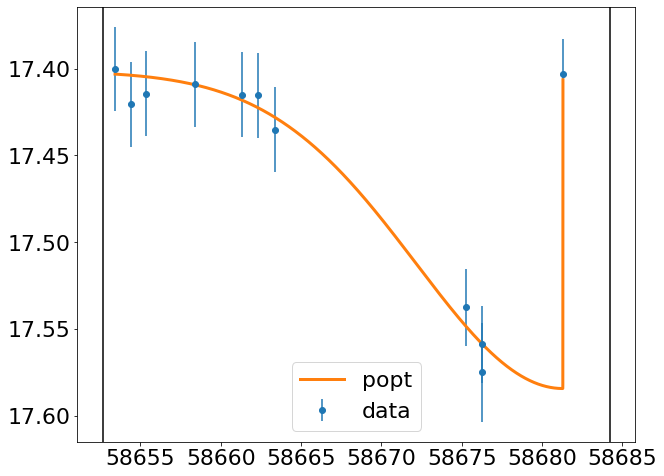


    id               = 192812606877181861
    dip.significance = 6.671697616577148
    fit_r.skew       = 3.8269882202148438
    


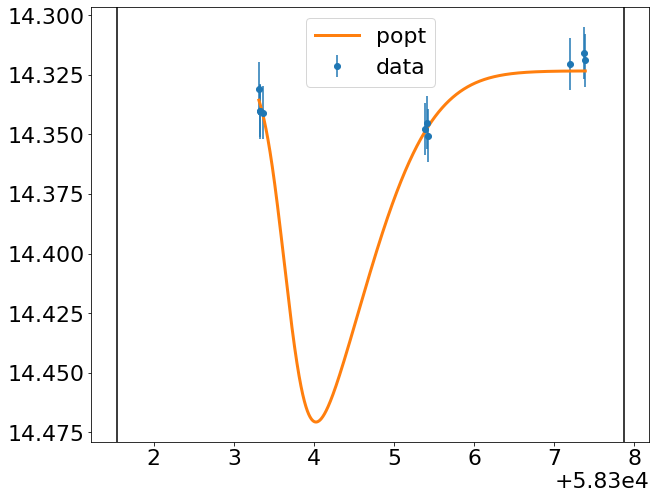


    id               = 85022588485331000
    dip.significance = 7.693305492401123
    fit_r.skew       = -10.567697525024414
    


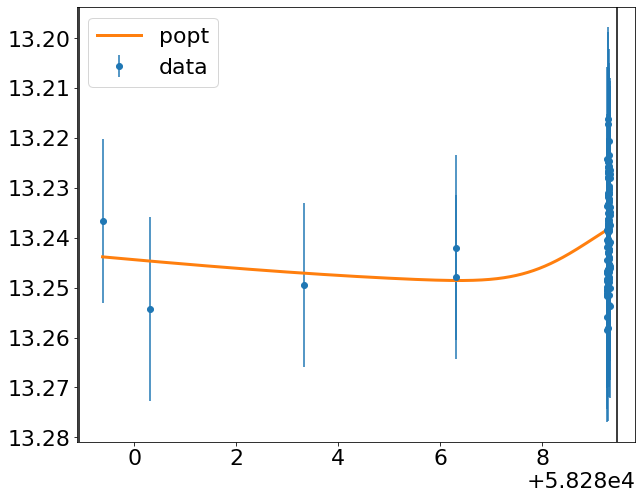


    id               = 85022588485331000
    dip.significance = 7.693305492401123
    fit_r.skew       = -10.567697525024414
    


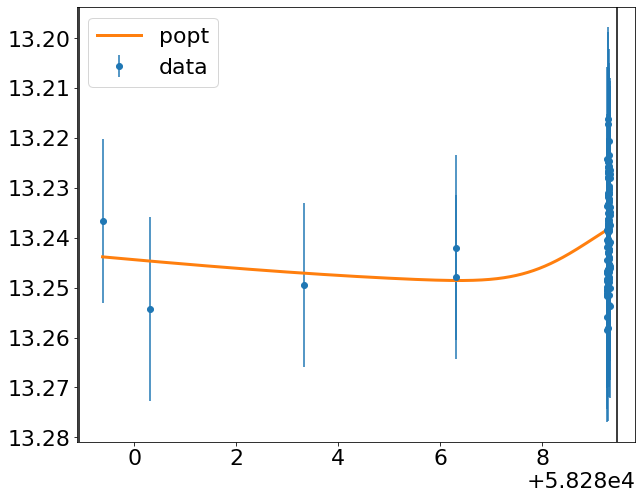


    id               = 107402834045122313
    dip.significance = 5.990357875823975
    fit_r.skew       = -12.896806716918945
    


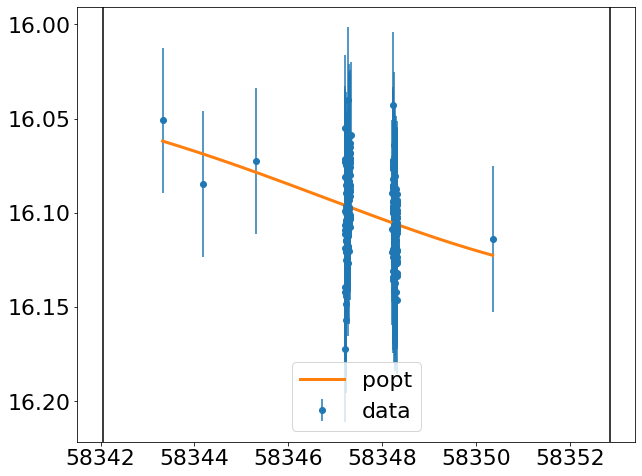


    id               = 107402834045122313
    dip.significance = 5.990357875823975
    fit_r.skew       = -12.896806716918945
    


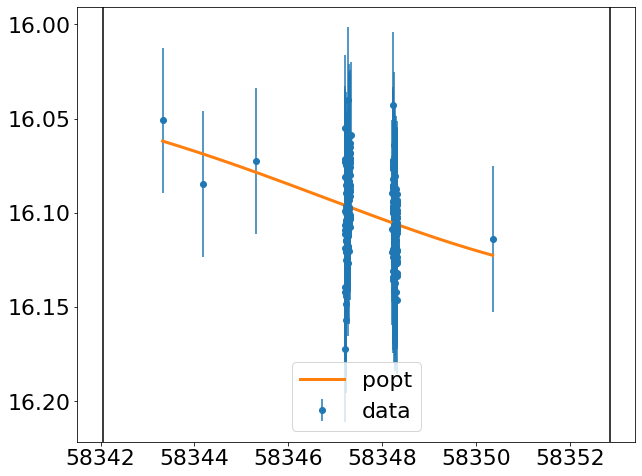


    id               = 77132608295343505
    dip.significance = 6.214999675750732
    fit_r.skew       = 2.5110301971435547
    


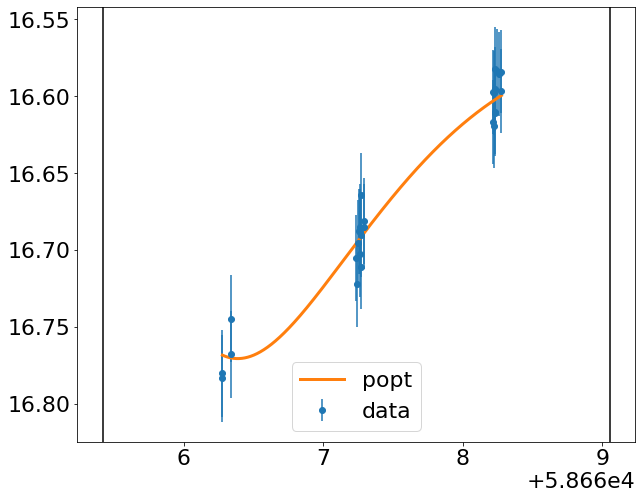


    id               = 204290592340267242
    dip.significance = 5.554558753967285
    fit_r.skew       = 2.83251953125
    


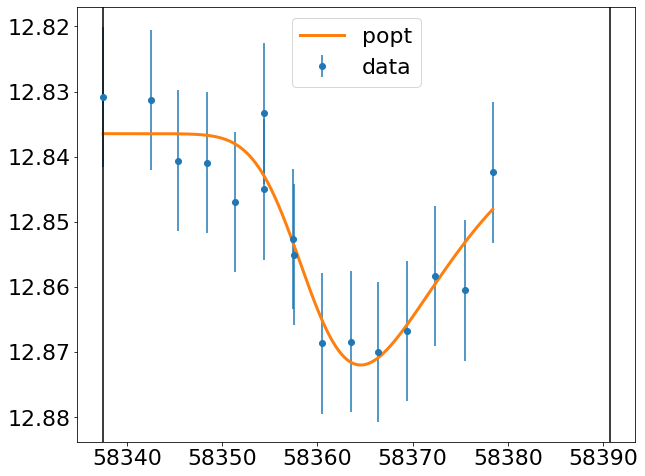


    id               = 105772868691832500
    dip.significance = 5.129798412322998
    fit_r.skew       = 2.7022407054901123
    


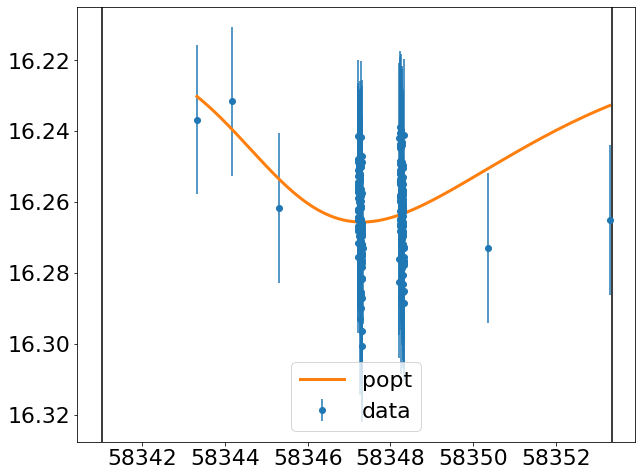

In [13]:
nplot = 0
total = 10
for lc in fits_to_show_in_memory:
    if nplot == total:
        break
    x = lc['dip_window_r']['x']
    if len(x) < 10:
        continue
    else:
        nplot += 1
        
    y = lc['dip_window_r']['y']
    yerr = lc['dip_window_r']['yerr']
    fit = lc['fit_r']
    plot_fit_result(
        x, y, yerr, 
        fit, skew_normal
    )

    dip = lc['dip']
    
    plt.axvline(dip['start_mjd'], color="k", label="start")
    plt.axvline(dip['end_mjd'], color="k", label="end")
    print("""
    id               = {}
    dip.significance = {}
    fit_r.skew       = {}
    """.format(
        lc['ps1_objid'],
        dip['significance'],
        fit['popt'][0]
    ))
    plt.gca().invert_yaxis()
    plt.show()

# Cut data using in-window $\chi^2$

In [14]:
fits_to_show_window_error = skew_normal_fits.where(
    # chi_square / ndof < 5
    (skew_normal_fits['model_error_around_dip_r.reduced_sum_square_error'] < 5) &  
    (
        #  2 < skew or skew < -2
        (skew_normal_fits['fit_r.popt'][0] > 2) | (skew_normal_fits['fit_r.popt'][0] < -2)
    )
).sort(
    skew_normal_fits['dip.significance'],
    ascending=False
)

In [15]:
fits_to_show_window_error_in_memory = fits_to_show_window_error.collect()

In [16]:
len(fits_to_show_window_error_in_memory)

27979


    id               = 159090937538846181
    dip.significance = 35.32625961303711
    fit_r.skew       = -3.2222628593444824
    


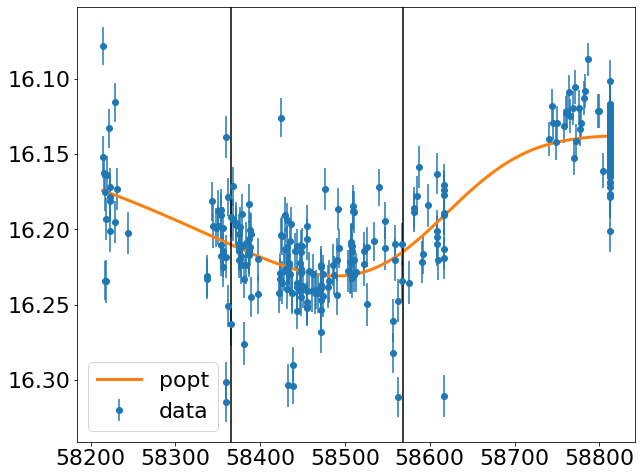


    id               = 133592971966272490
    dip.significance = 33.28120040893555
    fit_r.skew       = 3.7814714908599854
    


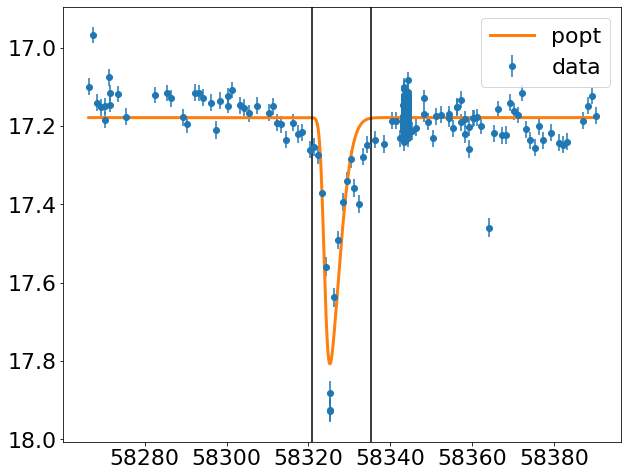


    id               = 107611037749611530
    dip.significance = 26.744962692260742
    fit_r.skew       = -11.579530715942383
    


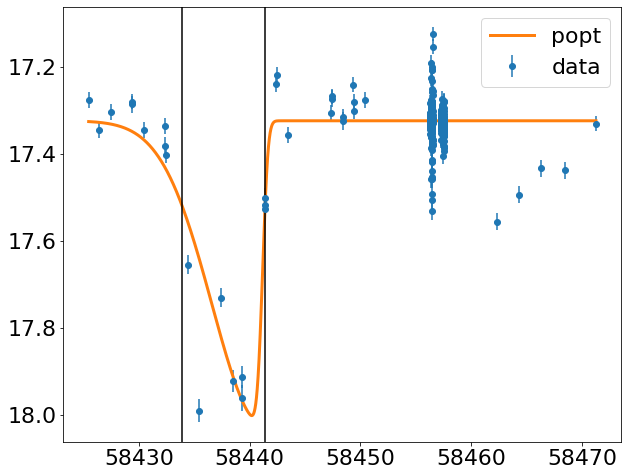


    id               = 131123129860725804
    dip.significance = 26.454347610473633
    fit_r.skew       = -3.334491491317749
    


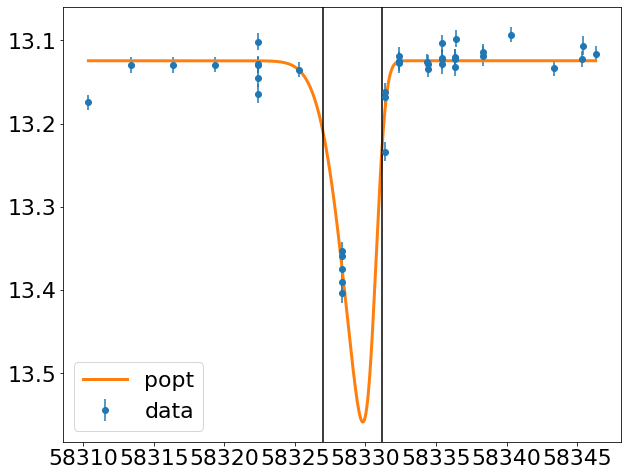


    id               = 129882947896818809
    dip.significance = 25.71099090576172
    fit_r.skew       = 111.6928482055664
    


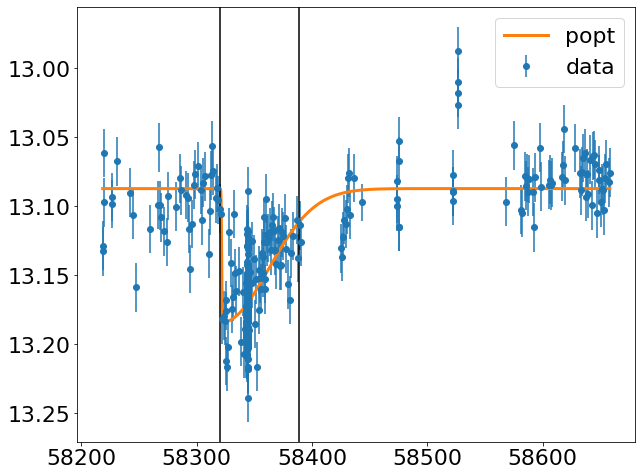


    id               = 147000815022480182
    dip.significance = 25.67387580871582
    fit_r.skew       = -2.895460844039917
    


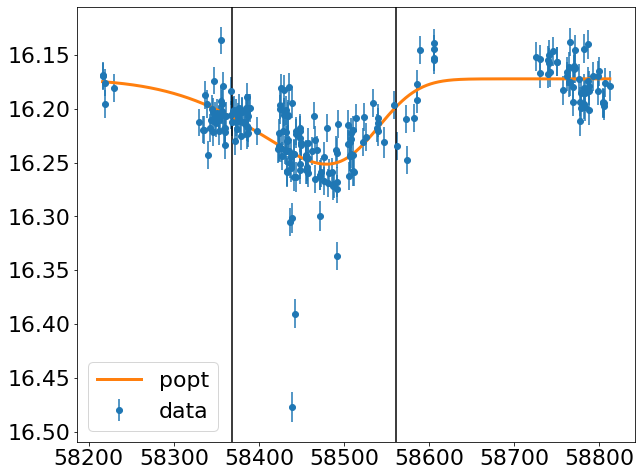


    id               = 121362944148527847
    dip.significance = 24.705665588378906
    fit_r.skew       = -4.928668975830078
    


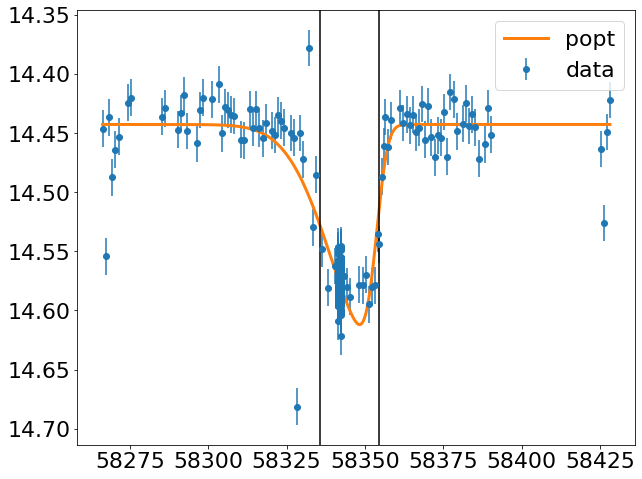


    id               = 78632590997885819
    dip.significance = 24.447803497314453
    fit_r.skew       = 2.601550579071045
    


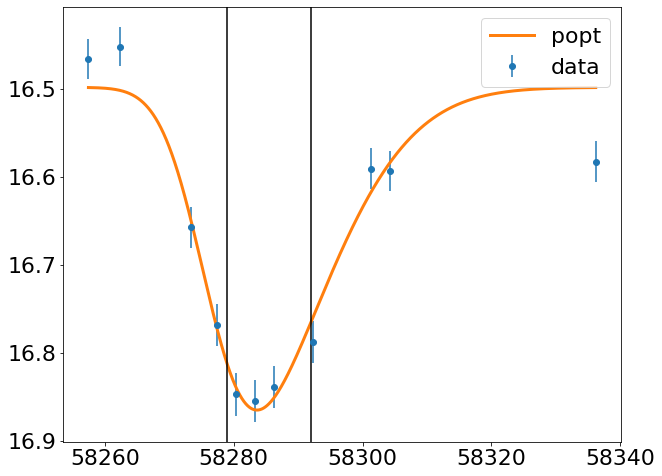


    id               = 109472958641450241
    dip.significance = 24.17249870300293
    fit_r.skew       = 5.215034008026123
    


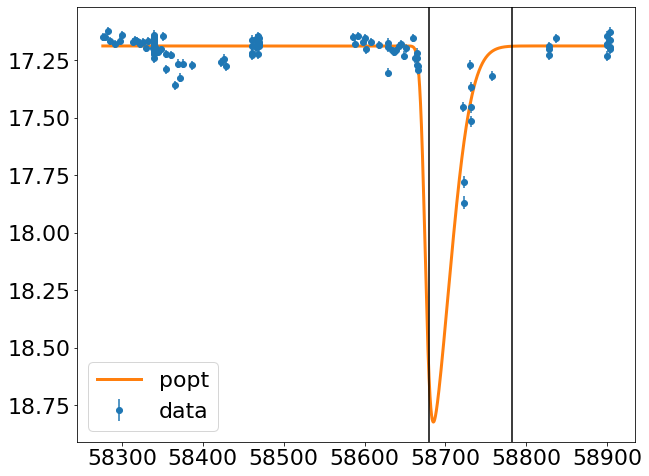


    id               = 174493453470111606
    dip.significance = 23.816293716430664
    fit_r.skew       = 5.17840576171875
    


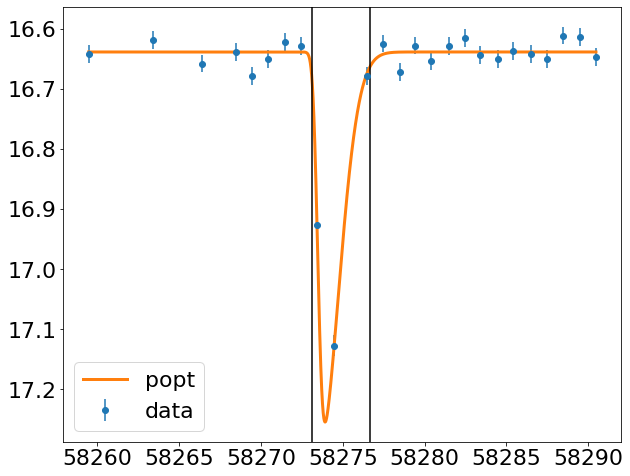


    id               = 139742968399803087
    dip.significance = 23.784608840942383
    fit_r.skew       = -9.245393753051758
    


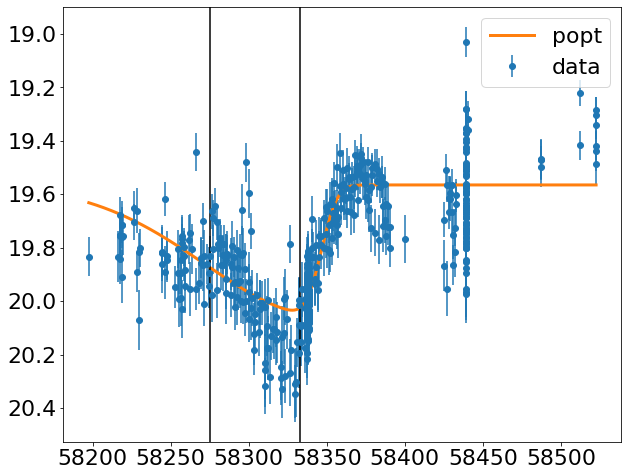


    id               = 139742968399803087
    dip.significance = 23.784608840942383
    fit_r.skew       = -9.245393753051758
    


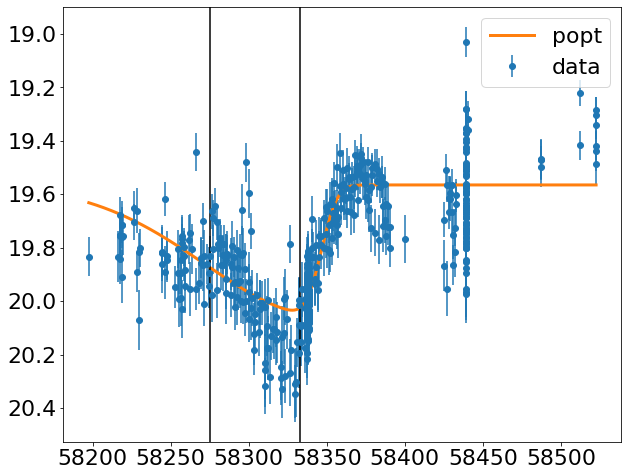


    id               = 154023044174687389
    dip.significance = 23.7554931640625
    fit_r.skew       = 2.199424982070923
    


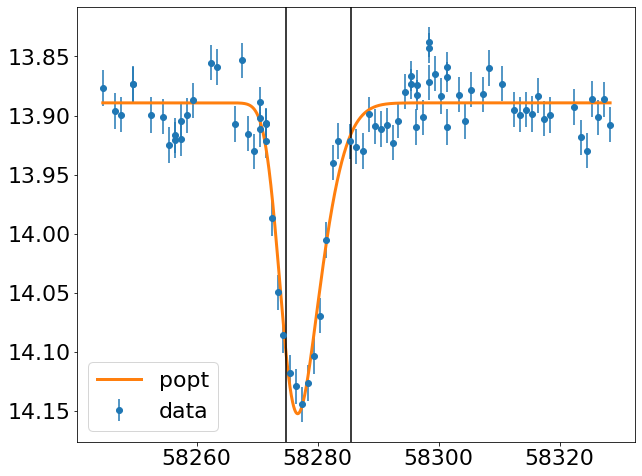


    id               = 141372956871058006
    dip.significance = 23.46469497680664
    fit_r.skew       = -2.506957769393921
    


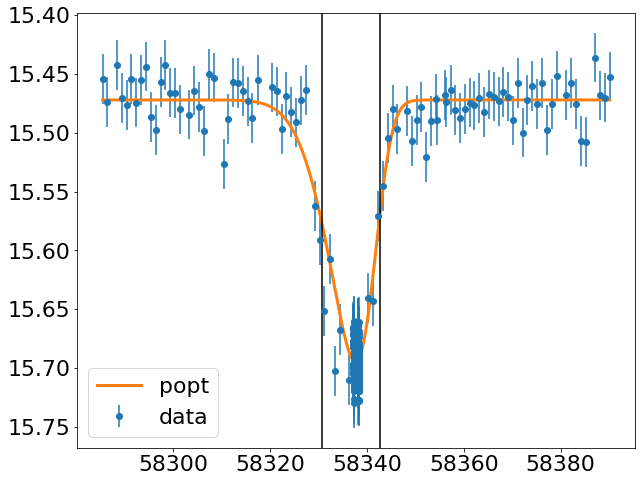


    id               = 107322831484070424
    dip.significance = 23.043537139892578
    fit_r.skew       = -3.2881343364715576
    


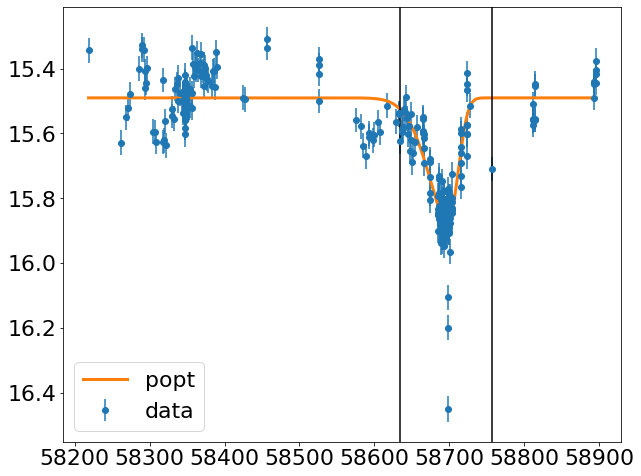


    id               = 139782964550564763
    dip.significance = 22.92140769958496
    fit_r.skew       = -2.824580430984497
    


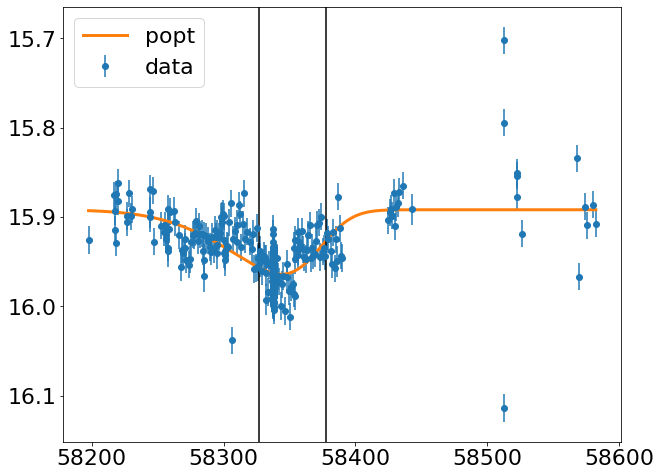


    id               = 102002832164600717
    dip.significance = 22.88143539428711
    fit_r.skew       = 2.5081708431243896
    


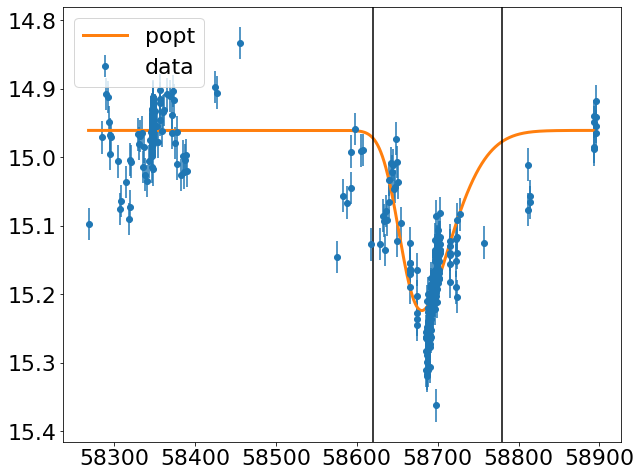


    id               = 102002832164600717
    dip.significance = 22.88143539428711
    fit_r.skew       = 2.5081708431243896
    


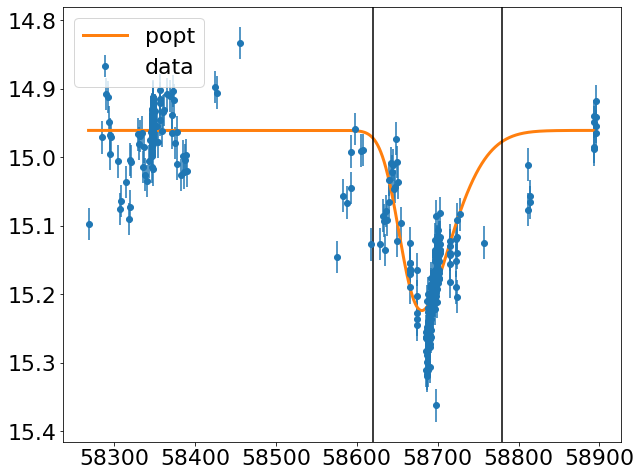


    id               = 162283062480199475
    dip.significance = 22.441946029663086
    fit_r.skew       = -13.048075675964355
    


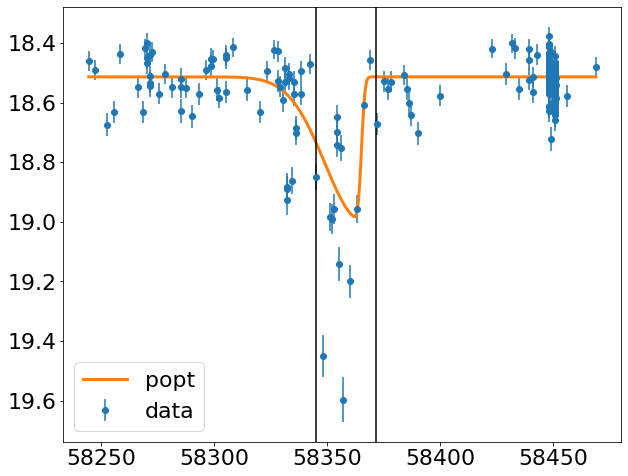


    id               = 174523510301184558
    dip.significance = 22.39006233215332
    fit_r.skew       = -4.150761604309082
    


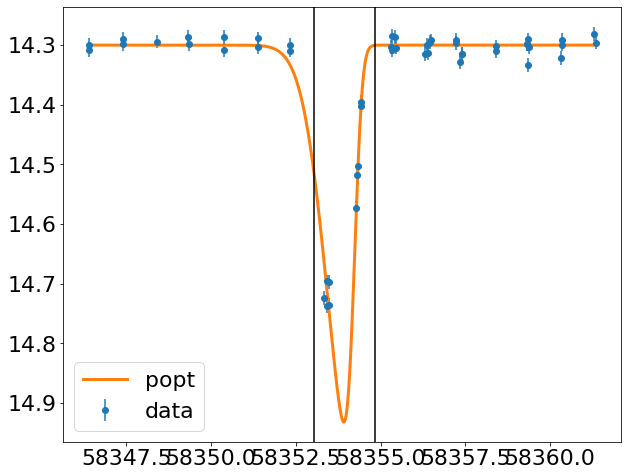


    id               = 118402912511650954
    dip.significance = 22.182559967041016
    fit_r.skew       = 281.98065185546875
    


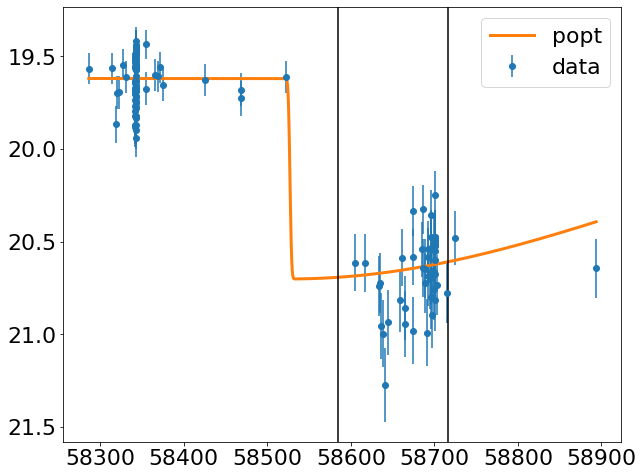


    id               = 118402912511650954
    dip.significance = 22.182559967041016
    fit_r.skew       = 281.98065185546875
    


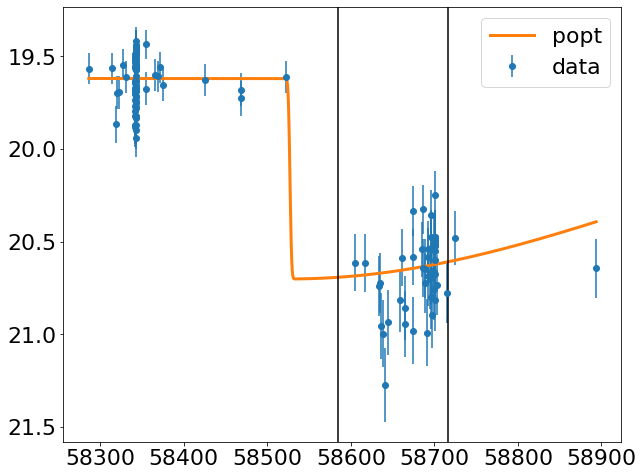


    id               = 123722823891529289
    dip.significance = 21.34234046936035
    fit_r.skew       = 2.7675392627716064
    


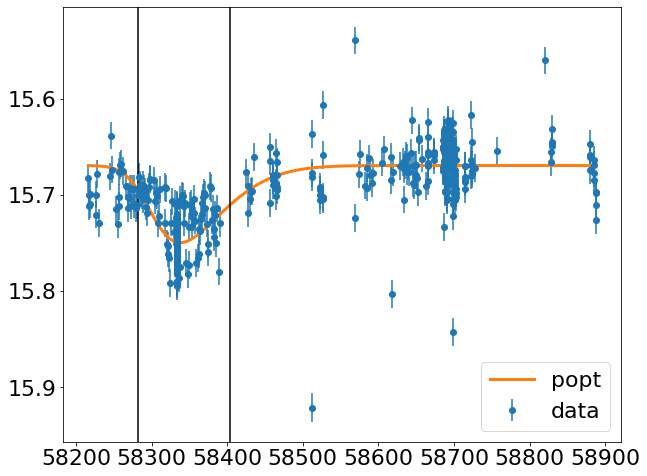


    id               = 108112869521631235
    dip.significance = 21.121496200561523
    fit_r.skew       = -2.1928420066833496
    


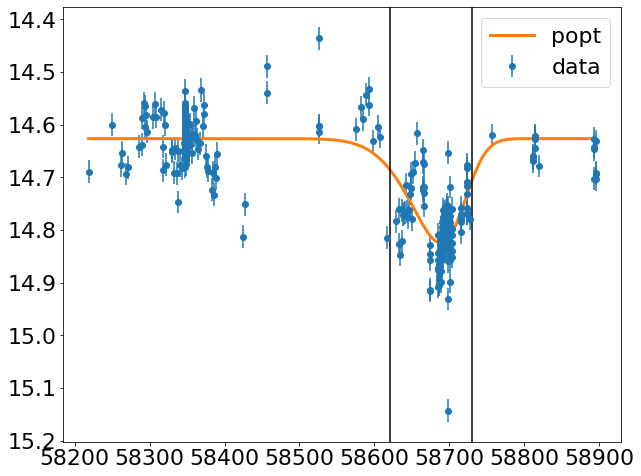


    id               = 126132855879540957
    dip.significance = 20.994558334350586
    fit_r.skew       = 2.366638422012329
    


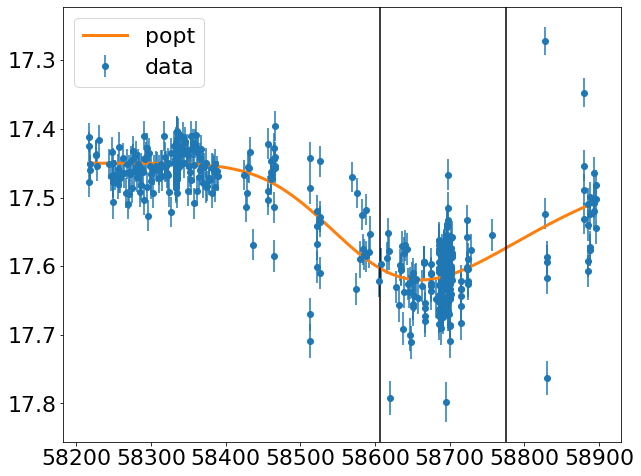


    id               = 108332829135592126
    dip.significance = 20.862224578857422
    fit_r.skew       = -3.0054640769958496
    


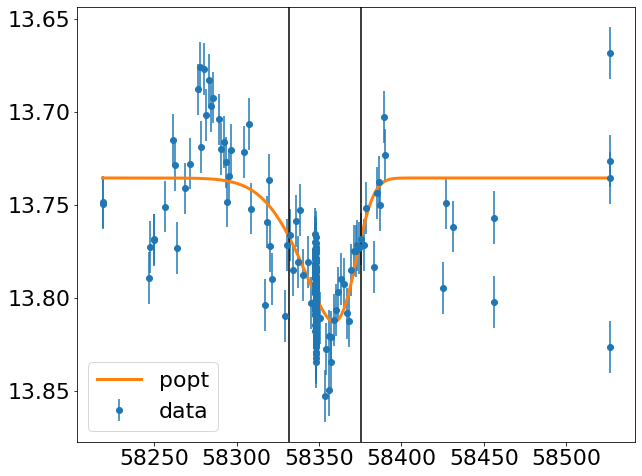


    id               = 121931751919216995
    dip.significance = 20.30562973022461
    fit_r.skew       = -10.5503568649292
    


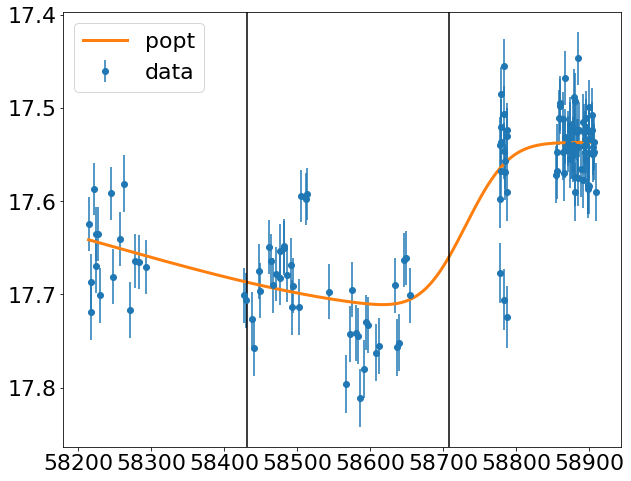


    id               = 126422474414525943
    dip.significance = 20.292137145996094
    fit_r.skew       = 5.35944128036499
    


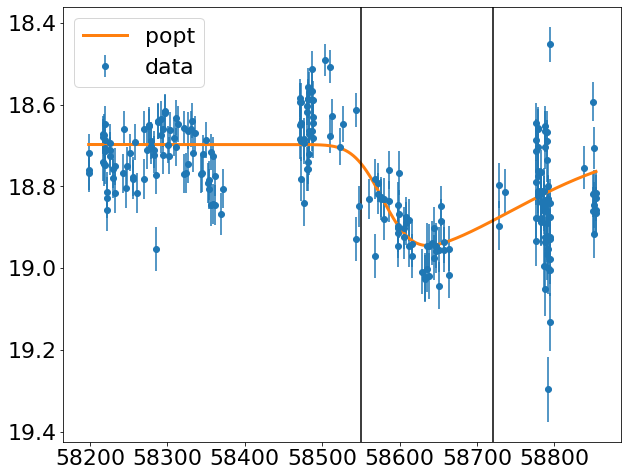


    id               = 164253065576452667
    dip.significance = 20.04683494567871
    fit_r.skew       = 5.175468921661377
    


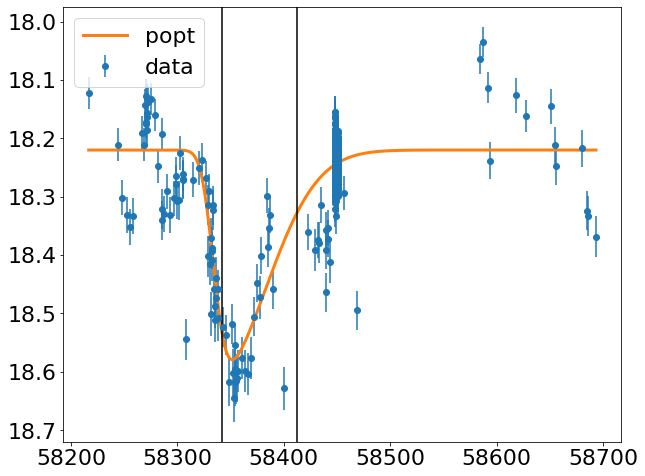


    id               = 144012972583475087
    dip.significance = 19.962244033813477
    fit_r.skew       = -2.279998779296875
    


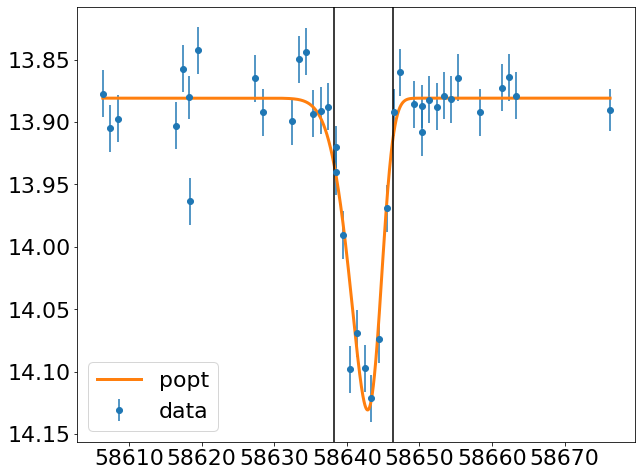


    id               = 104042840556744533
    dip.significance = 19.854244232177734
    fit_r.skew       = 3.5215606689453125
    


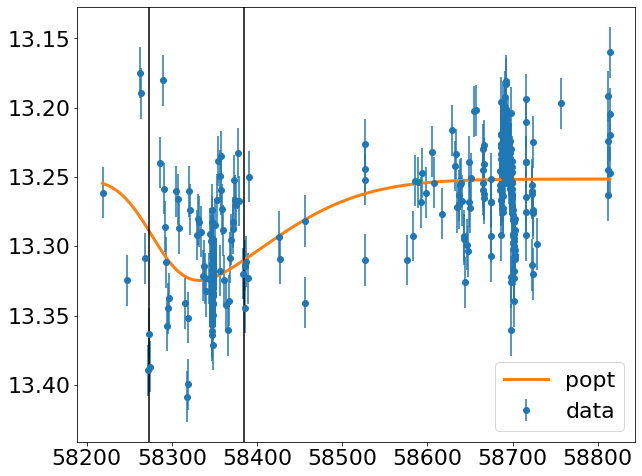


    id               = 175643379705894050
    dip.significance = 19.829299926757812
    fit_r.skew       = 2.3610007762908936
    


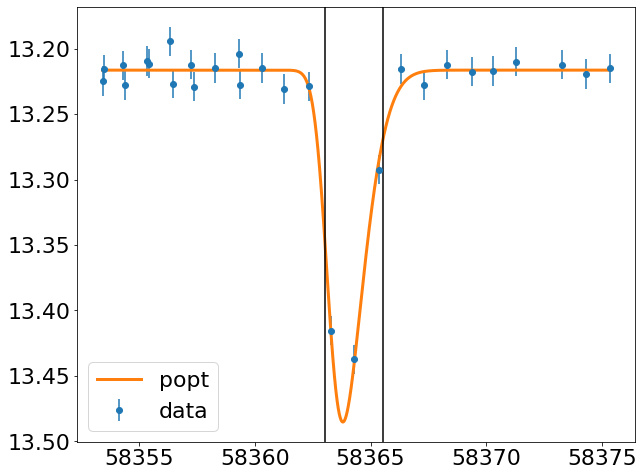


    id               = 170550148269843515
    dip.significance = 19.682710647583008
    fit_r.skew       = -4.6165080070495605
    


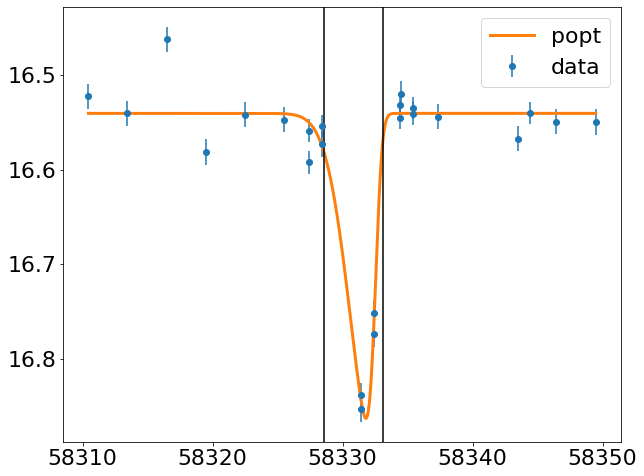


    id               = 93622748990865634
    dip.significance = 19.340959548950195
    fit_r.skew       = 2.2626380920410156
    


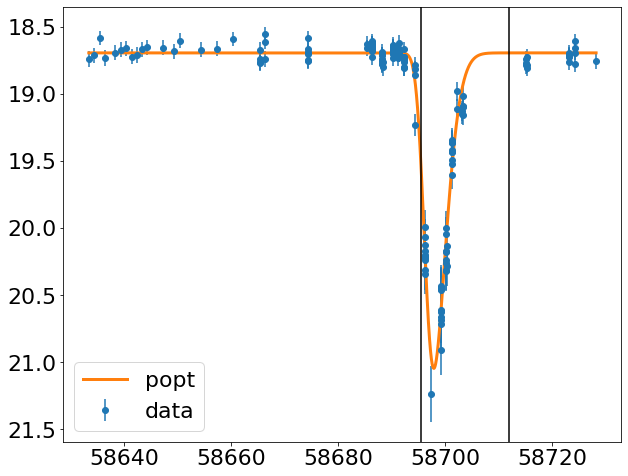


    id               = 78052570567589989
    dip.significance = 19.282289505004883
    fit_r.skew       = 33.88931655883789
    


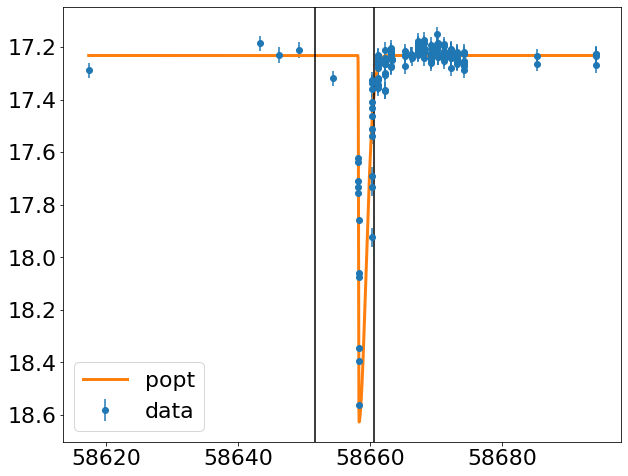


    id               = 108392864789623912
    dip.significance = 19.261560440063477
    fit_r.skew       = 5.708836555480957
    


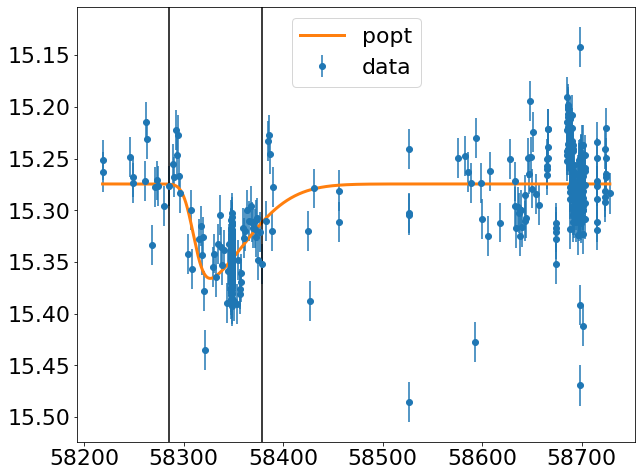


    id               = 127343016618770972
    dip.significance = 19.190475463867188
    fit_r.skew       = 497.4398193359375
    


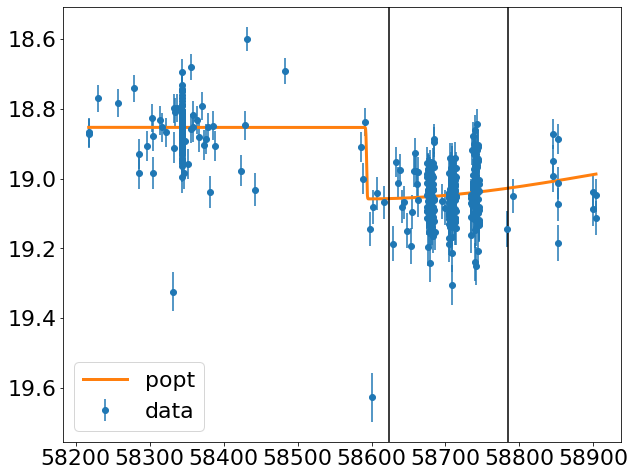


    id               = 127343016618770972
    dip.significance = 19.190475463867188
    fit_r.skew       = 497.4398193359375
    


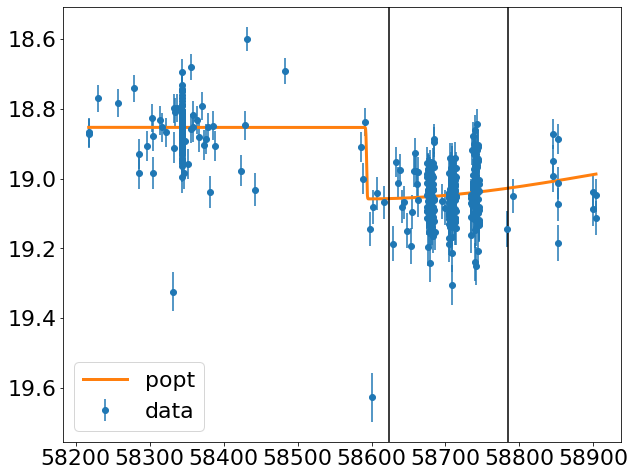


    id               = 165071177229185619
    dip.significance = 18.708332061767578
    fit_r.skew       = -6.550843715667725
    


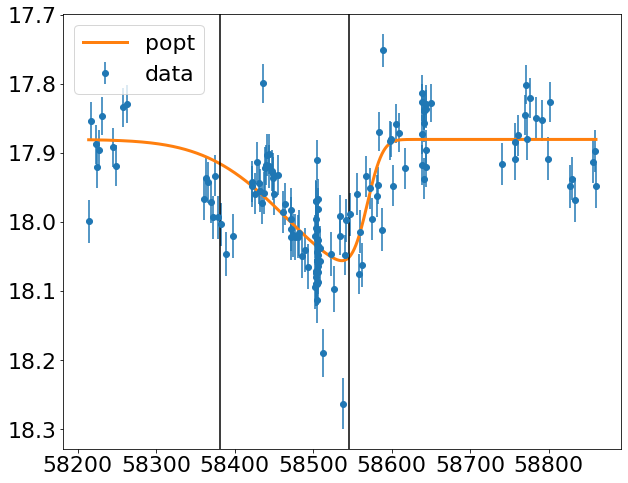


    id               = 86772788603079957
    dip.significance = 18.61186981201172
    fit_r.skew       = 3.4044759273529053
    


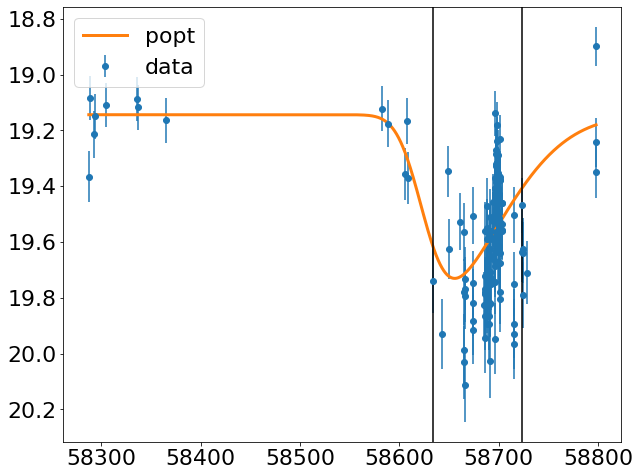


    id               = 108632911328657047
    dip.significance = 18.58343505859375
    fit_r.skew       = -8.130441665649414
    


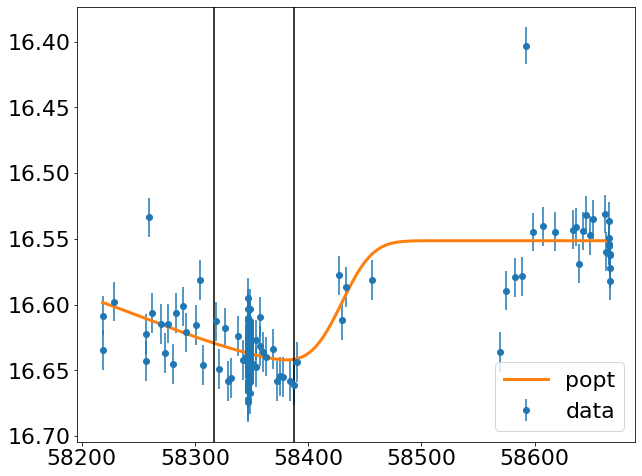


    id               = 121352755201084082
    dip.significance = 18.57744598388672
    fit_r.skew       = -11.464957237243652
    


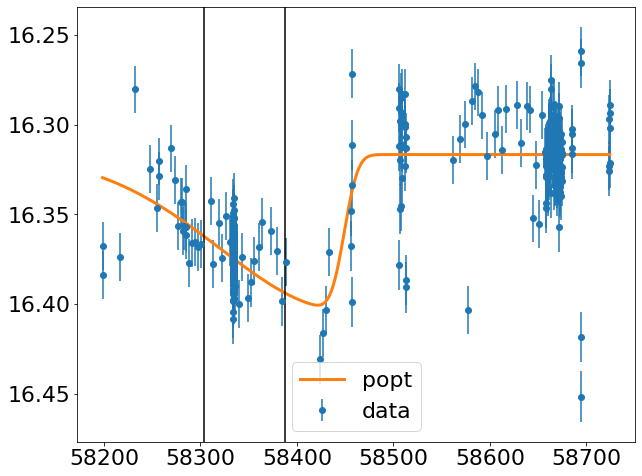


    id               = 137710901633851633
    dip.significance = 18.418556213378906
    fit_r.skew       = -5.7952399253845215
    


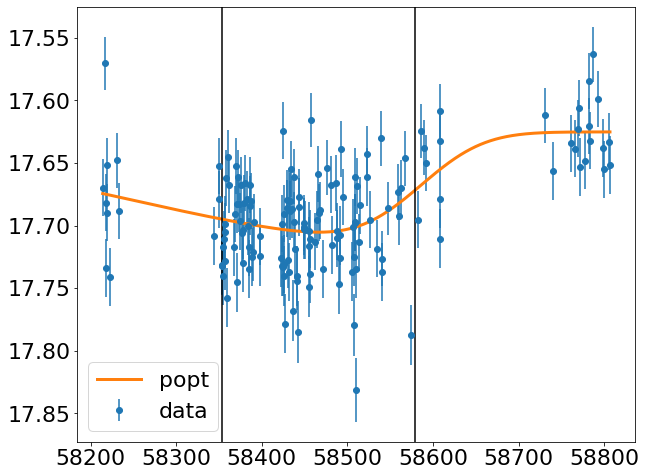


    id               = 167451279362265514
    dip.significance = 18.390897750854492
    fit_r.skew       = -4.030576229095459
    


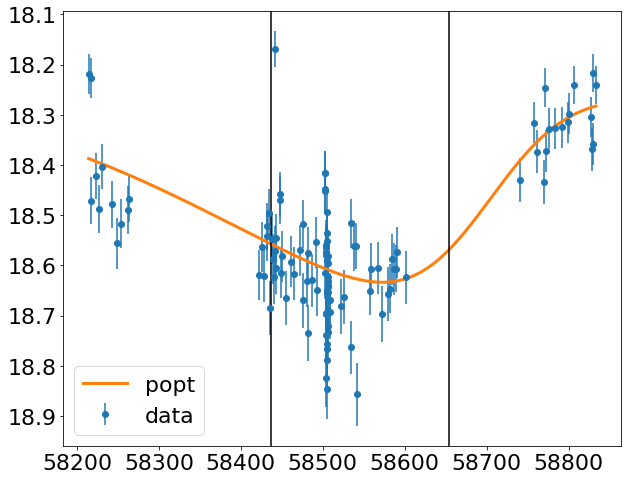


    id               = 125821023178589155
    dip.significance = 18.322961807250977
    fit_r.skew       = -2488.100341796875
    


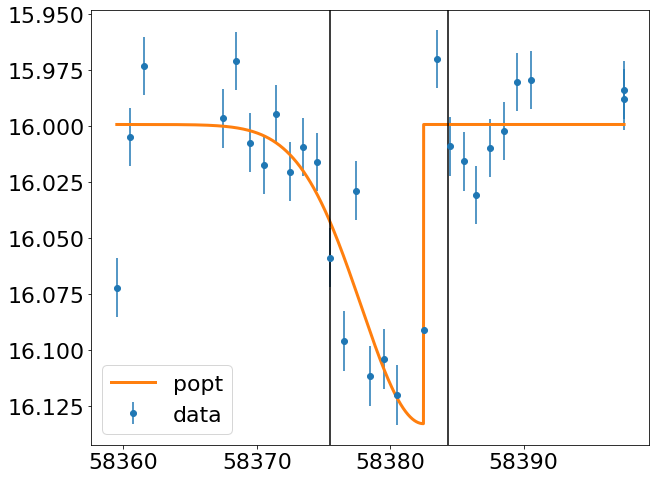


    id               = 103612832430382320
    dip.significance = 18.079801559448242
    fit_r.skew       = 9.690956115722656
    


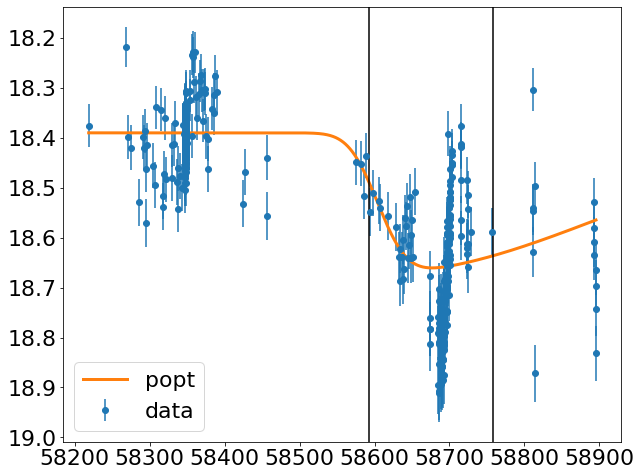


    id               = 161803137966395478
    dip.significance = 18.014925003051758
    fit_r.skew       = 8.96599006652832
    


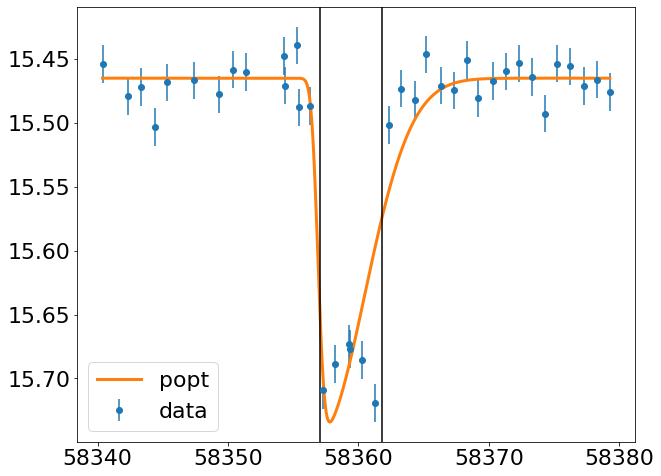


    id               = 111052903936515355
    dip.significance = 18.00975799560547
    fit_r.skew       = 2.9897005558013916
    


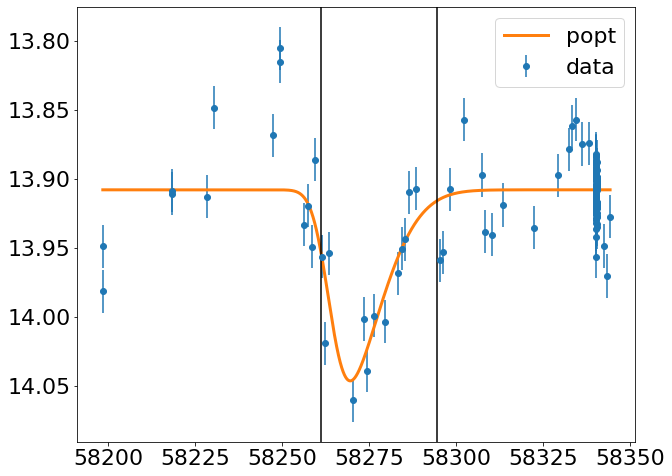


    id               = 134970965695389322
    dip.significance = 17.910097122192383
    fit_r.skew       = -2.8301193714141846
    


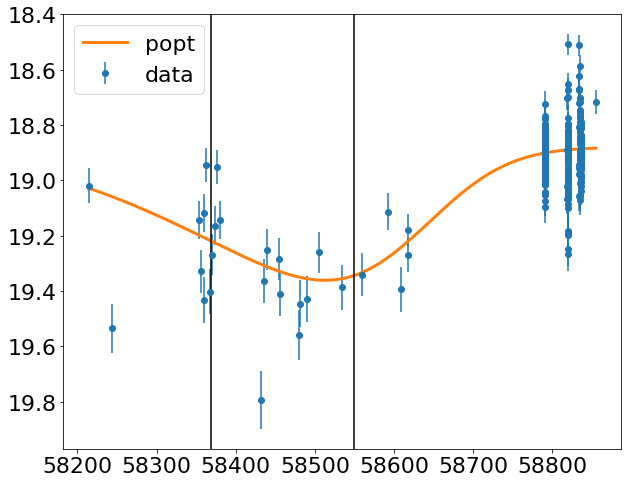


    id               = 125122854976880353
    dip.significance = 17.787141799926758
    fit_r.skew       = -21.35570526123047
    


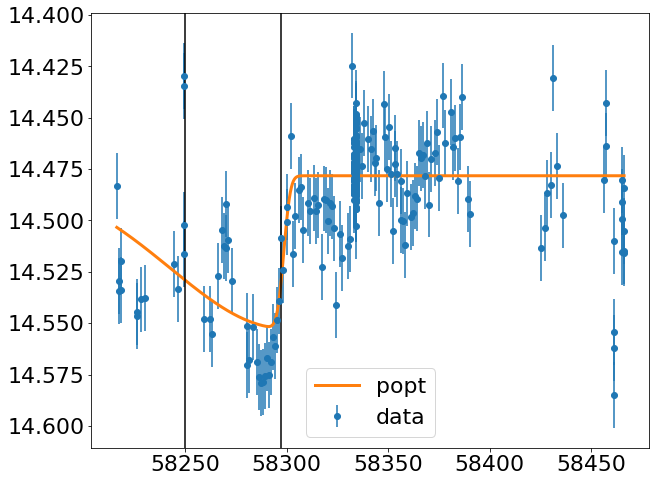


    id               = 139171471555890328
    dip.significance = 17.78385353088379
    fit_r.skew       = 4.067445278167725
    


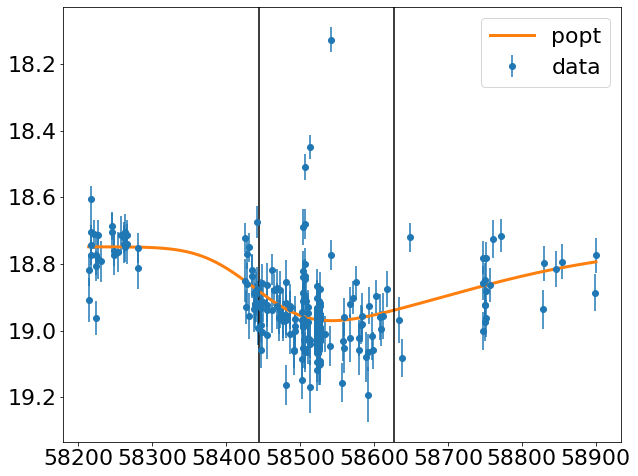


    id               = 163583138607224078
    dip.significance = 17.726512908935547
    fit_r.skew       = -2.525753974914551
    


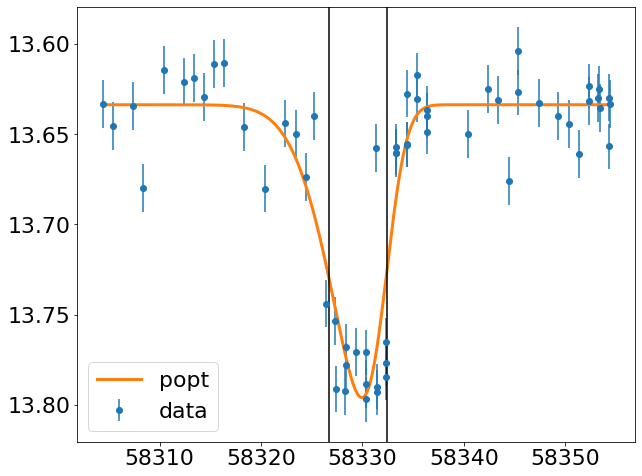


    id               = 118022851262879473
    dip.significance = 17.62985610961914
    fit_r.skew       = -5.355002403259277
    


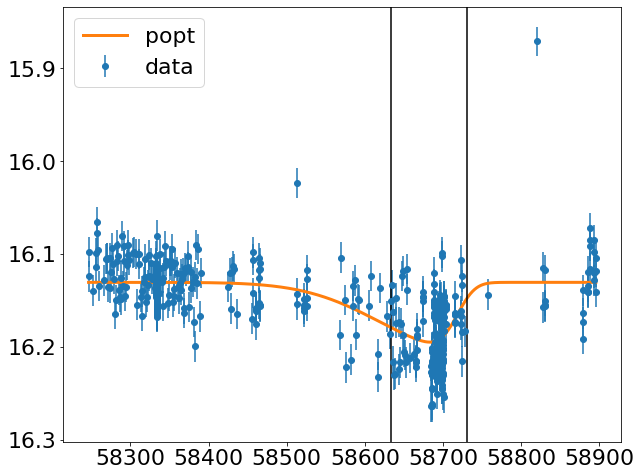


    id               = 123792931004067936
    dip.significance = 17.590944290161133
    fit_r.skew       = -63.65338134765625
    


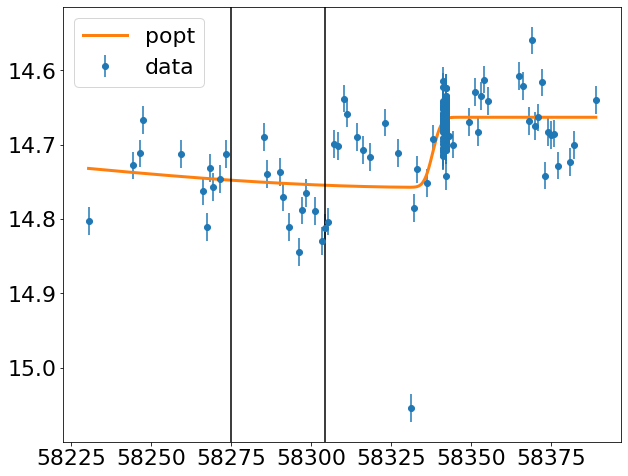


    id               = 159171011493366577
    dip.significance = 17.554399490356445
    fit_r.skew       = -22886.625
    


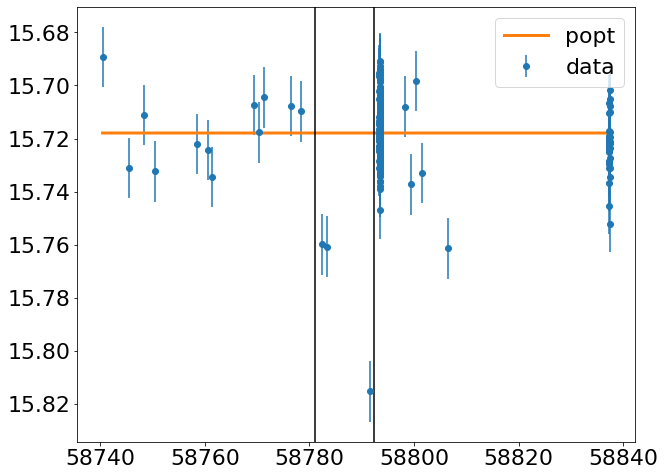


    id               = 153011419725000544
    dip.significance = 17.49786949157715
    fit_r.skew       = -3.4681477546691895
    


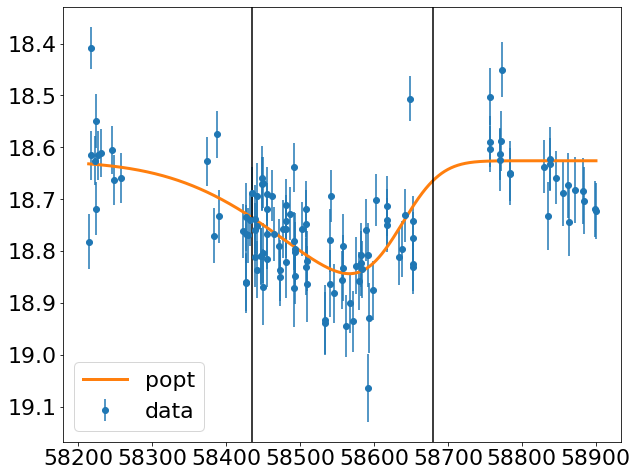


    id               = 102822815473135089
    dip.significance = 17.497100830078125
    fit_r.skew       = 4.633982181549072
    


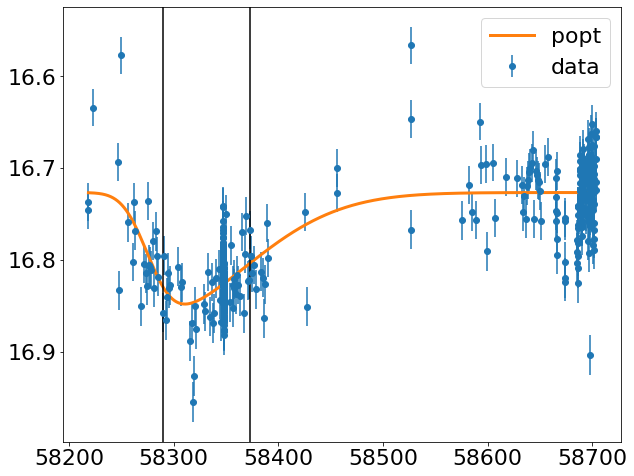


    id               = 160232216918453999
    dip.significance = 17.438514709472656
    fit_r.skew       = 2.8488261699676514
    


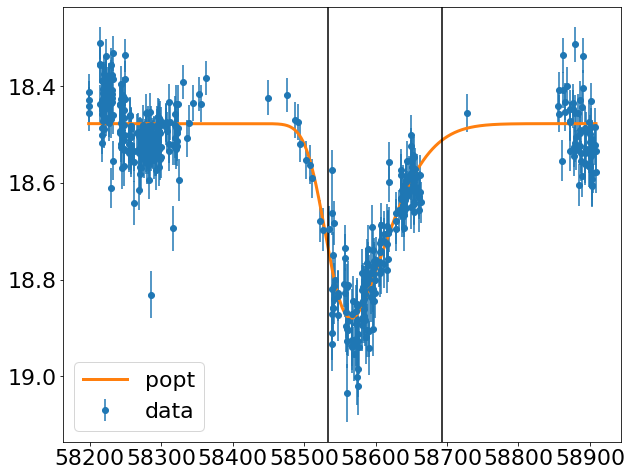


    id               = 125012881773328025
    dip.significance = 17.386470794677734
    fit_r.skew       = -3.182603597640991
    


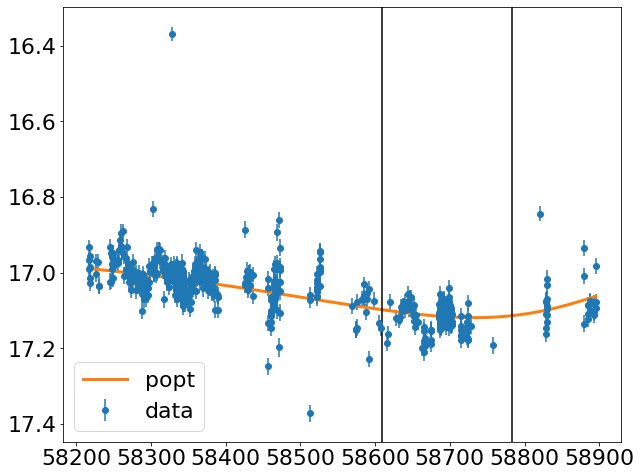


    id               = 104062842481886874
    dip.significance = 17.306621551513672
    fit_r.skew       = -7.796336650848389
    


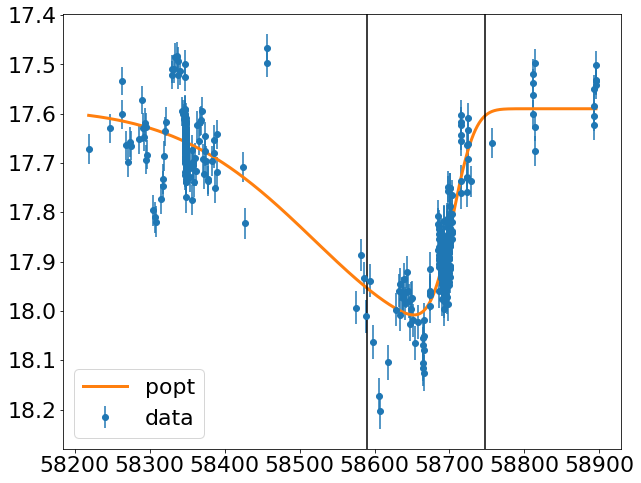


    id               = 101852777145664335
    dip.significance = 17.27921485900879
    fit_r.skew       = -2.8756237030029297
    


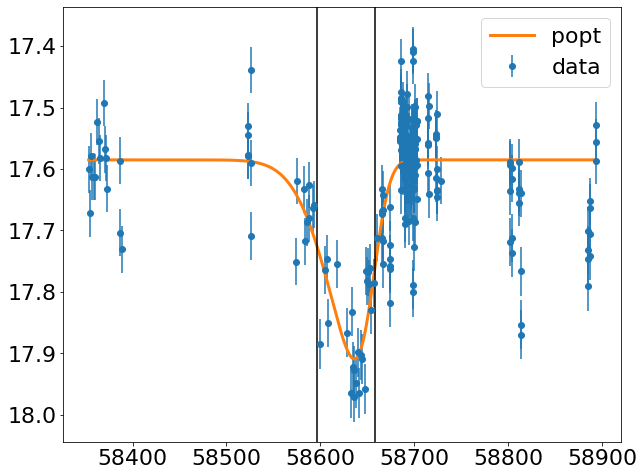


    id               = 136622962523299505
    dip.significance = 17.17356300354004
    fit_r.skew       = 8.682516098022461
    


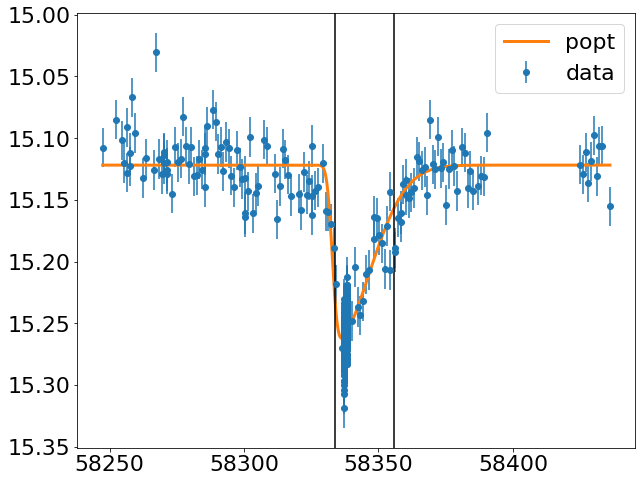


    id               = 96072838511946113
    dip.significance = 17.15765380859375
    fit_r.skew       = 2.6115026473999023
    


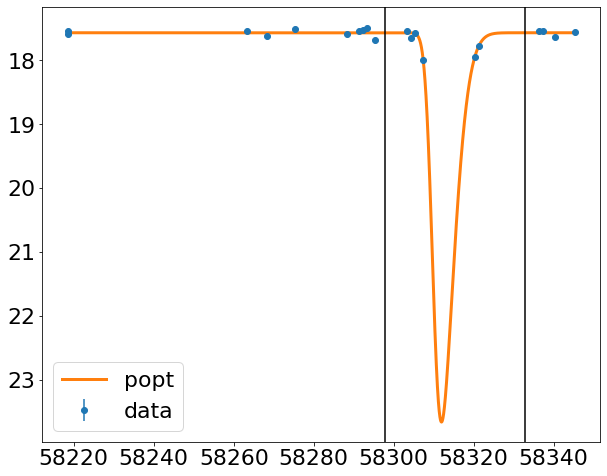


    id               = 150812905494789157
    dip.significance = 17.109140396118164
    fit_r.skew       = -2.7519359588623047
    


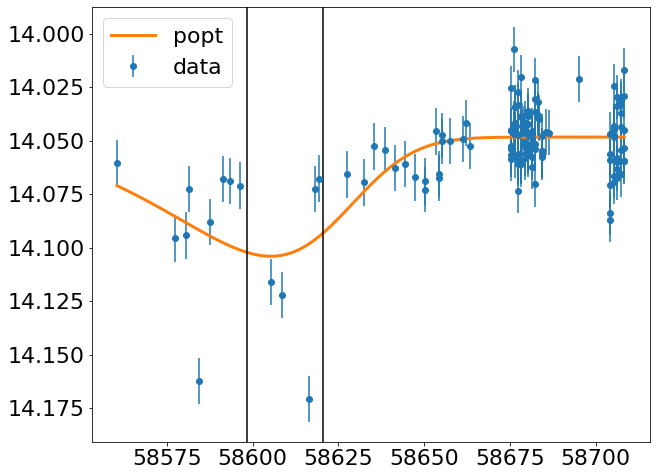


    id               = 107612835552590636
    dip.significance = 17.07964324951172
    fit_r.skew       = 4.482227325439453
    


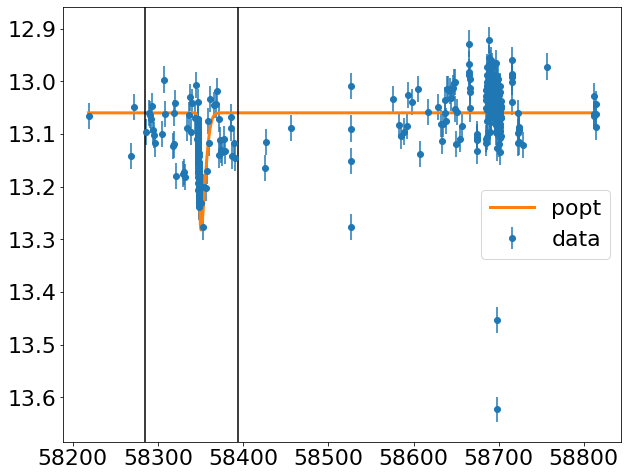


    id               = 144012972582514858
    dip.significance = 17.040124893188477
    fit_r.skew       = -2.4723596572875977
    


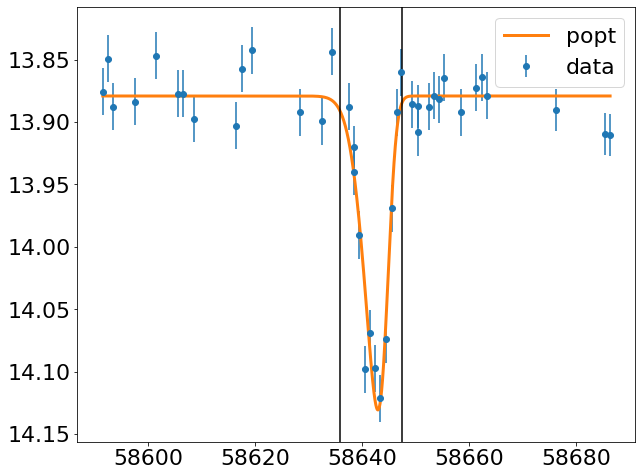


    id               = 181553588080059127
    dip.significance = 16.994104385375977
    fit_r.skew       = -68.64420318603516
    


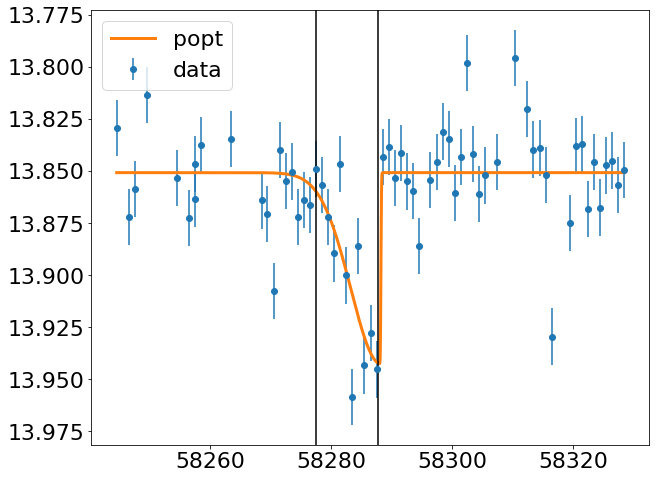


    id               = 169713230265413179
    dip.significance = 16.991493225097656
    fit_r.skew       = -2.6100993156433105
    


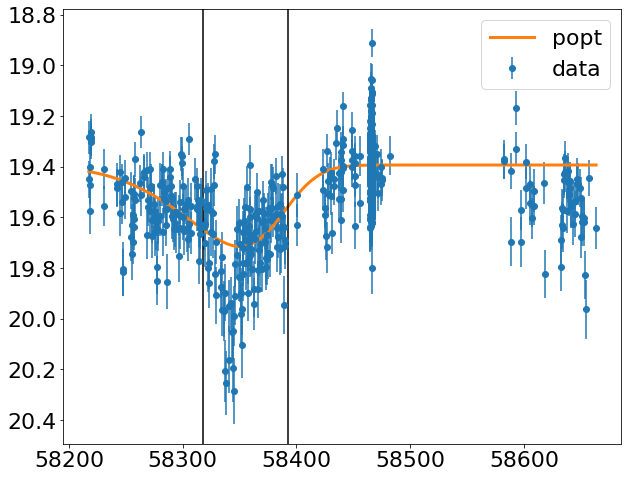


    id               = 106312837045252111
    dip.significance = 16.94841957092285
    fit_r.skew       = 3.125077486038208
    


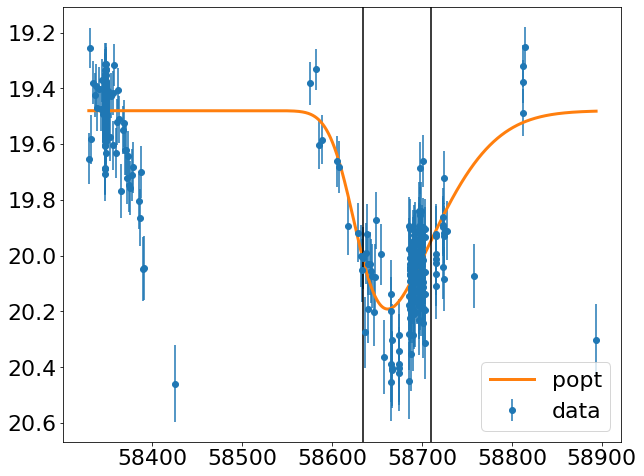


    id               = 160981391005436381
    dip.significance = 16.911653518676758
    fit_r.skew       = 3.2893178462982178
    


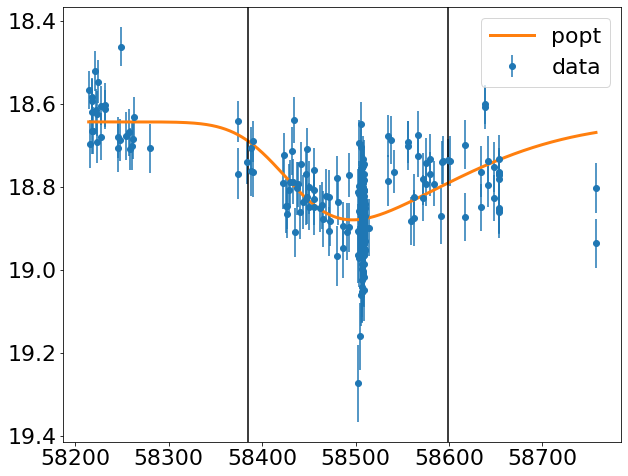


    id               = 152252898830577354
    dip.significance = 16.875385284423828
    fit_r.skew       = -6.215111255645752
    


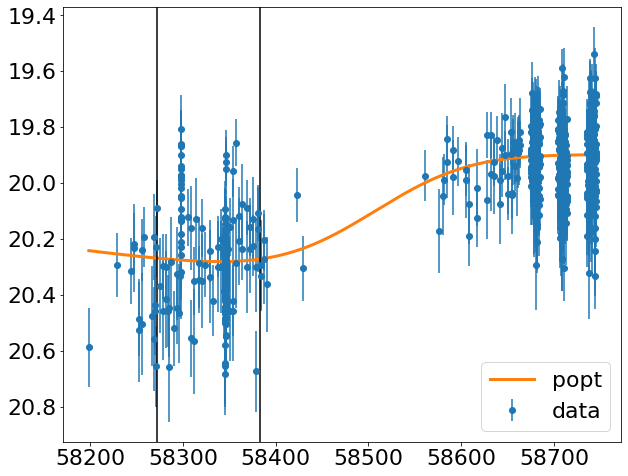


    id               = 126352766089351179
    dip.significance = 16.846038818359375
    fit_r.skew       = -2.187368392944336
    


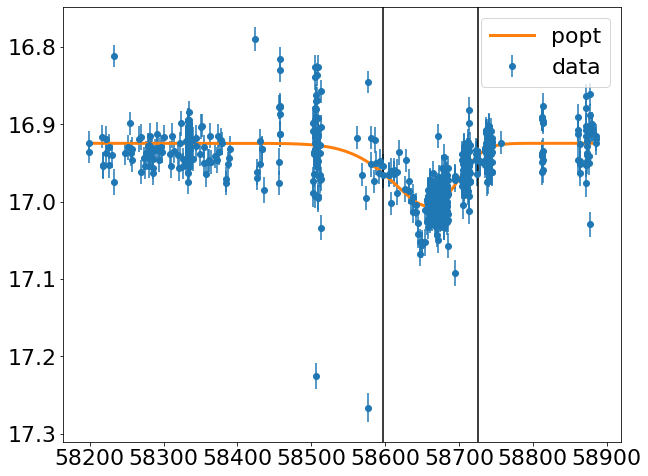


    id               = 132740979594745180
    dip.significance = 16.763519287109375
    fit_r.skew       = -3.77018666267395
    


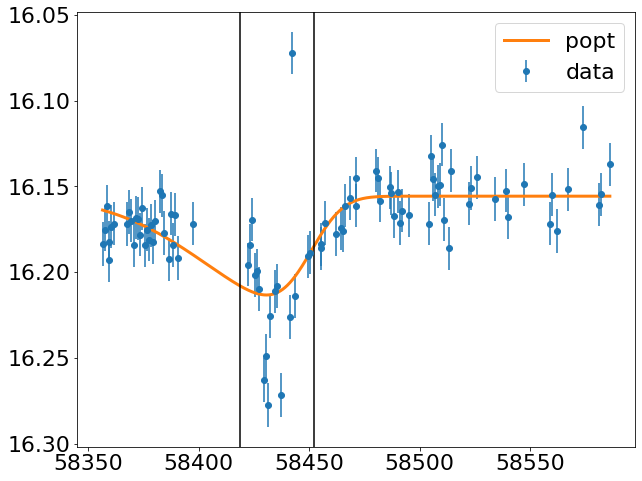


    id               = 162073227755860987
    dip.significance = 16.762435913085938
    fit_r.skew       = 2.4402637481689453
    


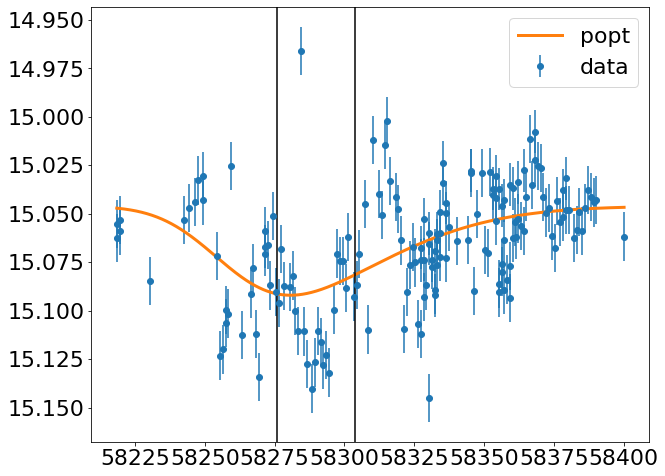


    id               = 112610912523884681
    dip.significance = 16.727859497070312
    fit_r.skew       = 2.416455030441284
    


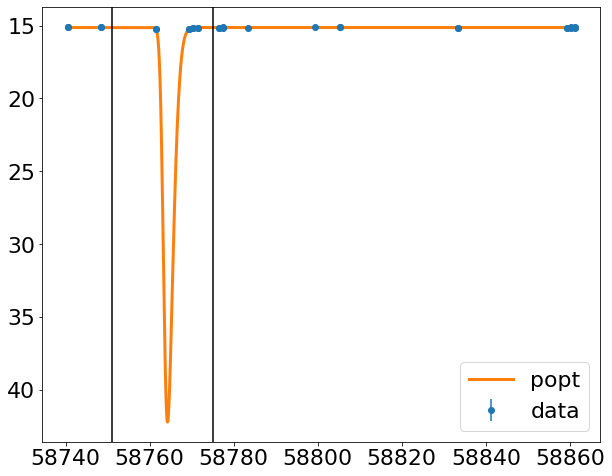


    id               = 115252876347732732
    dip.significance = 16.7262020111084
    fit_r.skew       = -4.048186779022217
    


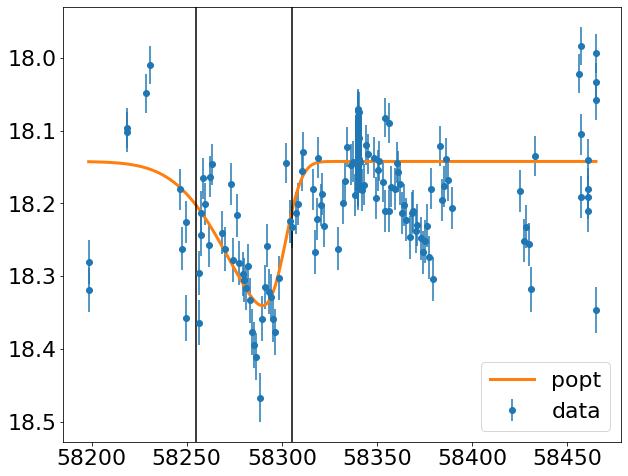


    id               = 118242779650356056
    dip.significance = 16.697607040405273
    fit_r.skew       = -22232.033203125
    


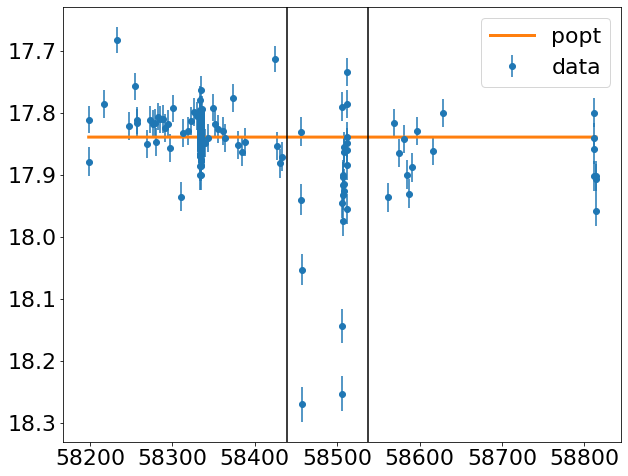


    id               = 163650567976527685
    dip.significance = 16.688283920288086
    fit_r.skew       = -657.9775390625
    


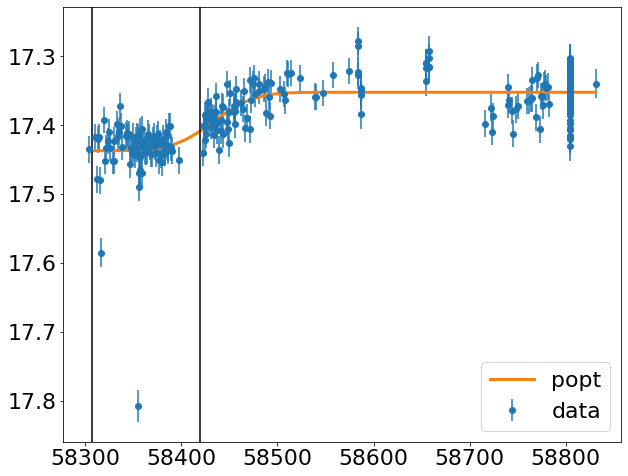


    id               = 120792803513788807
    dip.significance = 16.56340217590332
    fit_r.skew       = 4.203798294067383
    


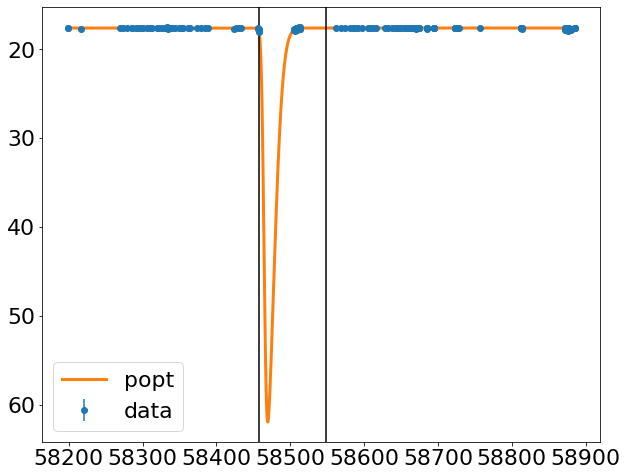


    id               = 106462848512310659
    dip.significance = 16.55994987487793
    fit_r.skew       = 2.160404920578003
    


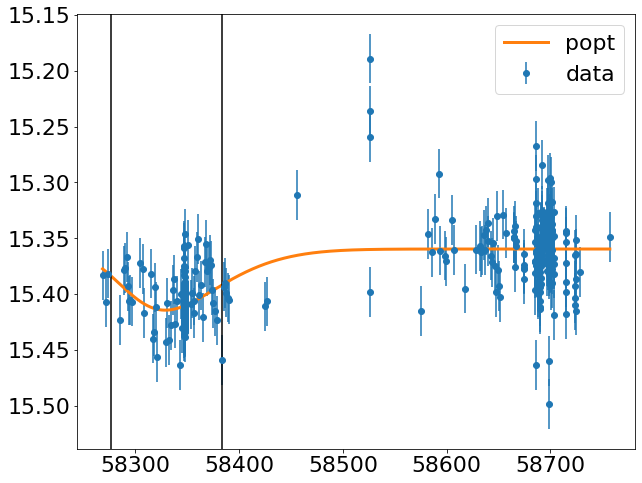


    id               = 106462848512310659
    dip.significance = 16.55994987487793
    fit_r.skew       = 2.160404920578003
    


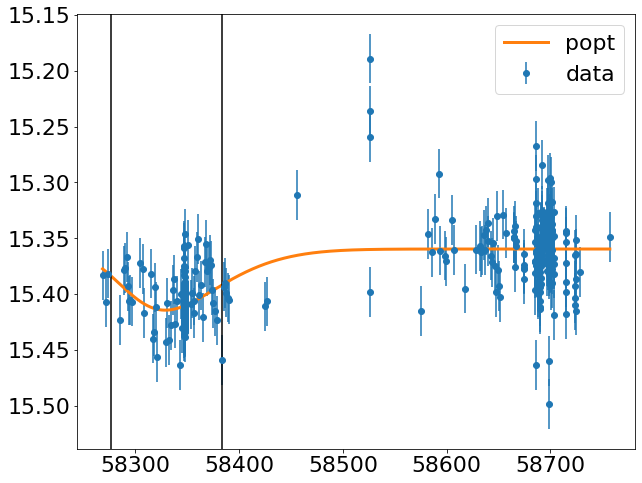


    id               = 102962851873698887
    dip.significance = 16.51377296447754
    fit_r.skew       = 4.579971790313721
    


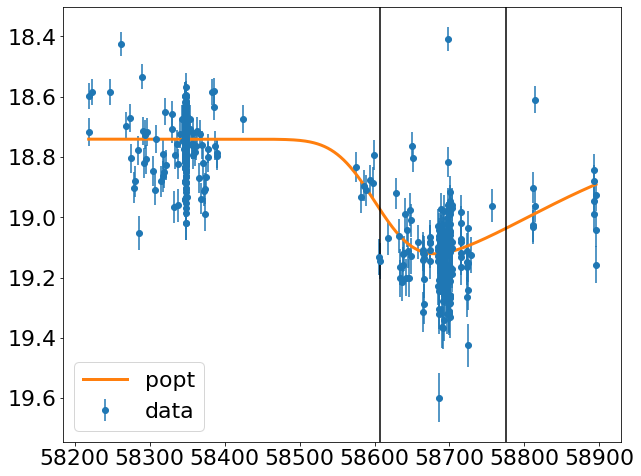


    id               = 170803295091604885
    dip.significance = 16.47737693786621
    fit_r.skew       = 13.95569133758545
    


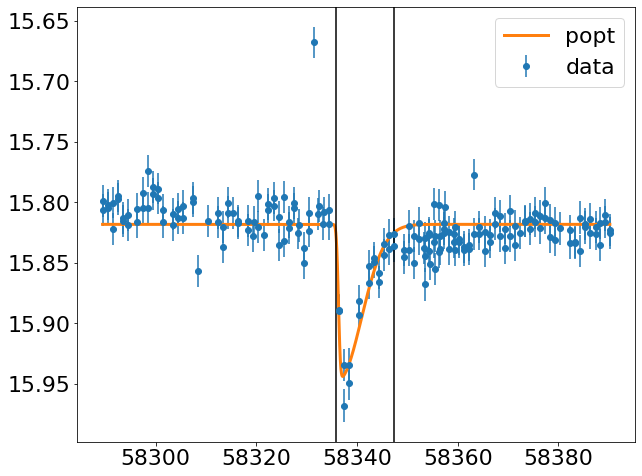


    id               = 103782874287619671
    dip.significance = 16.467891693115234
    fit_r.skew       = 611.6461181640625
    


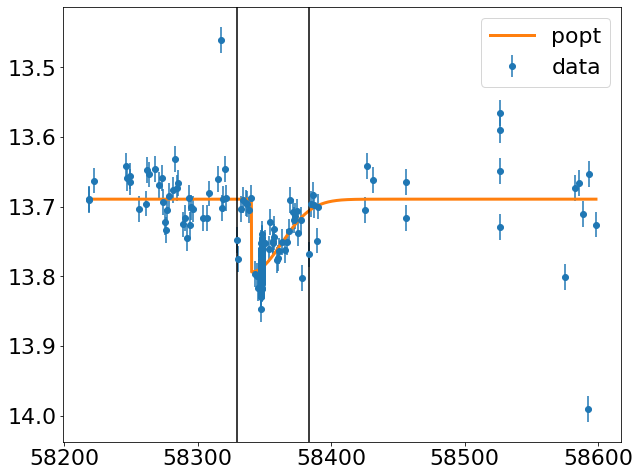


    id               = 183343451903968791
    dip.significance = 16.428600311279297
    fit_r.skew       = 3.7293691635131836
    


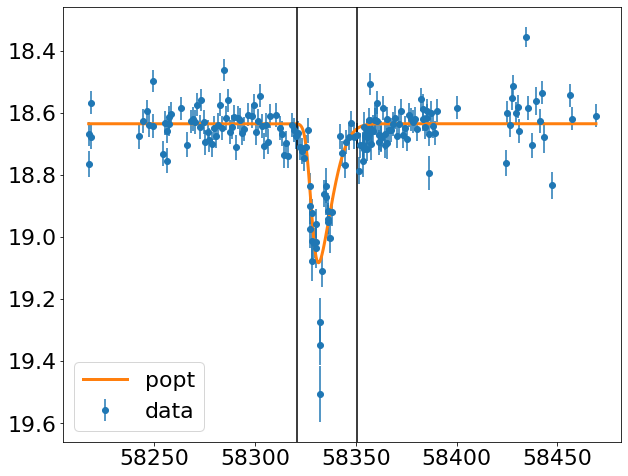


    id               = 165780421201216405
    dip.significance = 16.392078399658203
    fit_r.skew       = 4.669095993041992
    


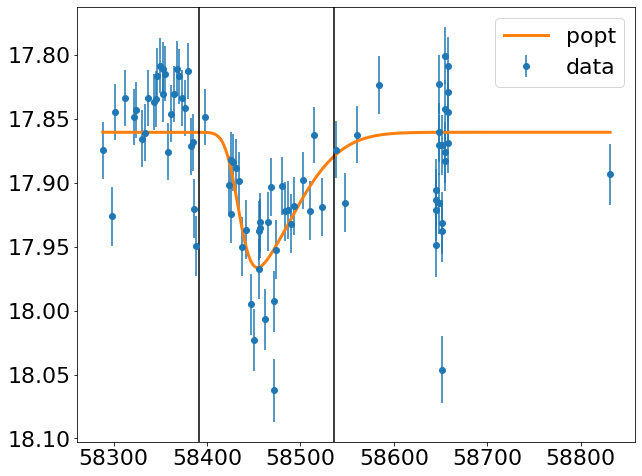


    id               = 115472918789817668
    dip.significance = 16.33369255065918
    fit_r.skew       = 4.999952793121338
    


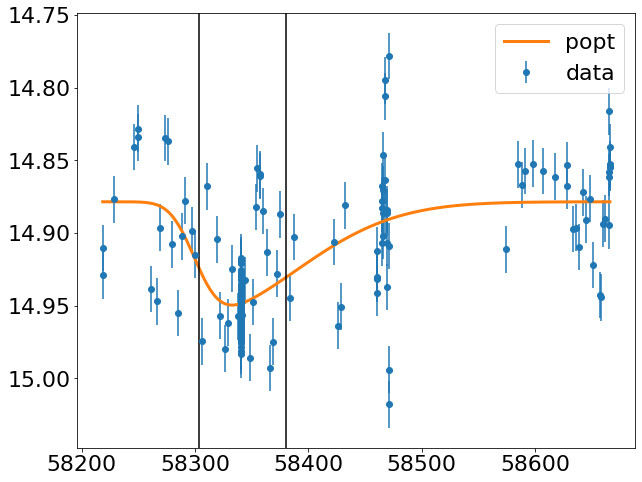


    id               = 165631887132557318
    dip.significance = 16.3292293548584
    fit_r.skew       = -4.938675403594971
    


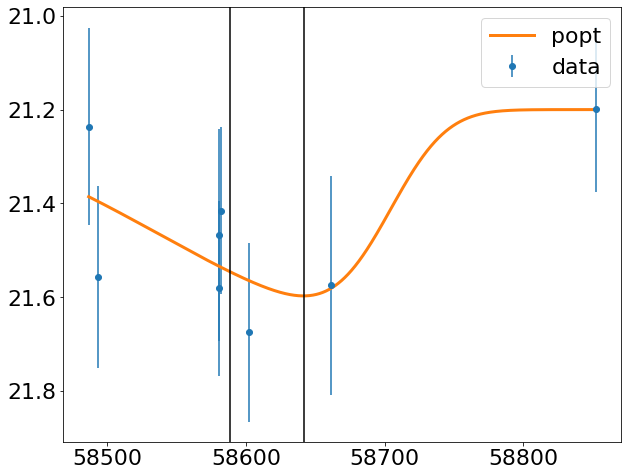


    id               = 107742849888824734
    dip.significance = 16.282888412475586
    fit_r.skew       = -3.25162672996521
    


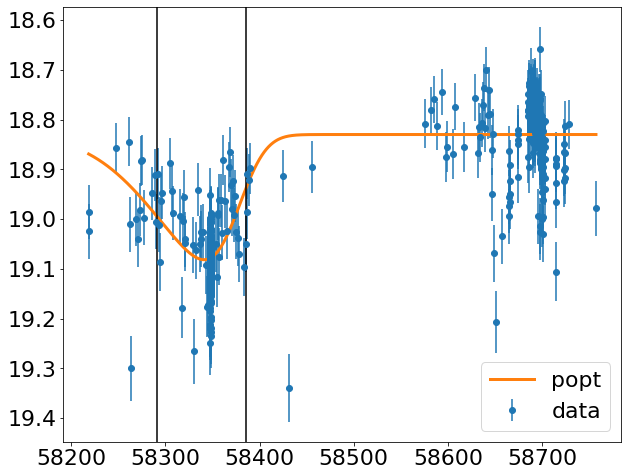


    id               = 107742849891074960
    dip.significance = 16.282888412475586
    fit_r.skew       = -3.2518441677093506
    


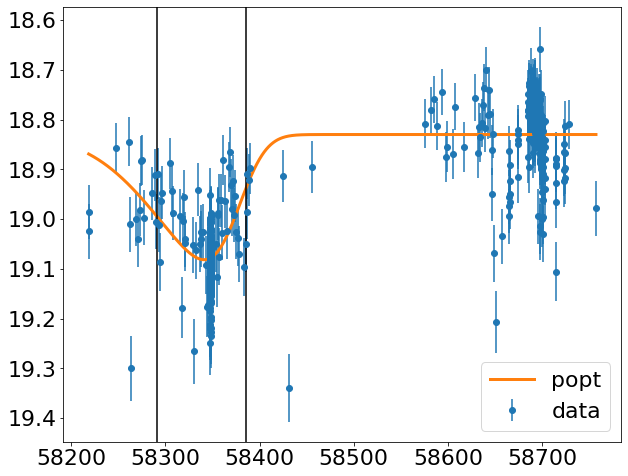


    id               = 128112954446970938
    dip.significance = 16.257125854492188
    fit_r.skew       = -2.7463817596435547
    


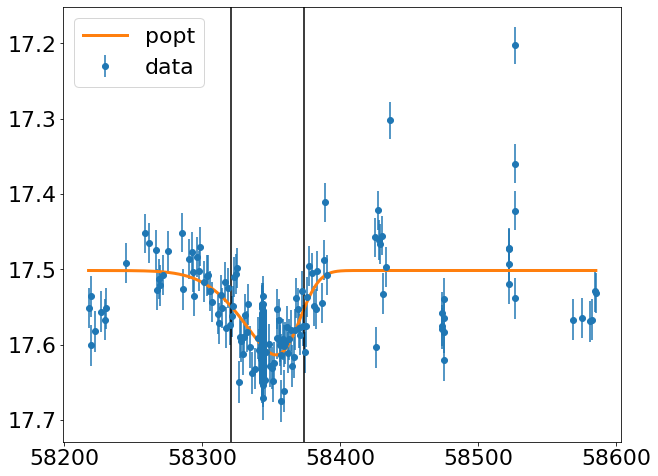


    id               = 119012780355349134
    dip.significance = 16.148595809936523
    fit_r.skew       = 2122.8876953125
    


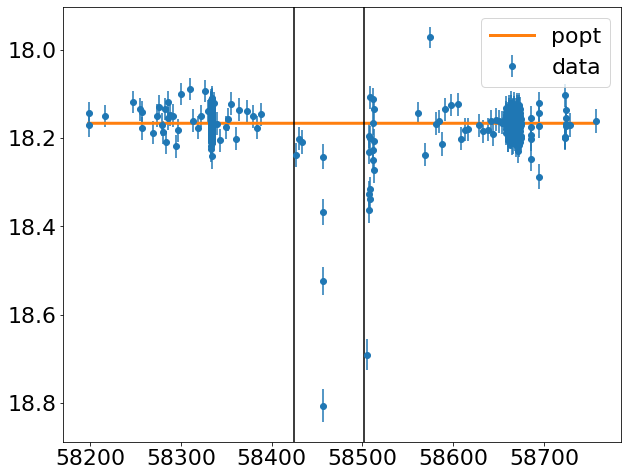


    id               = 178440179565632477
    dip.significance = 16.118515014648438
    fit_r.skew       = -2.4444868564605713
    


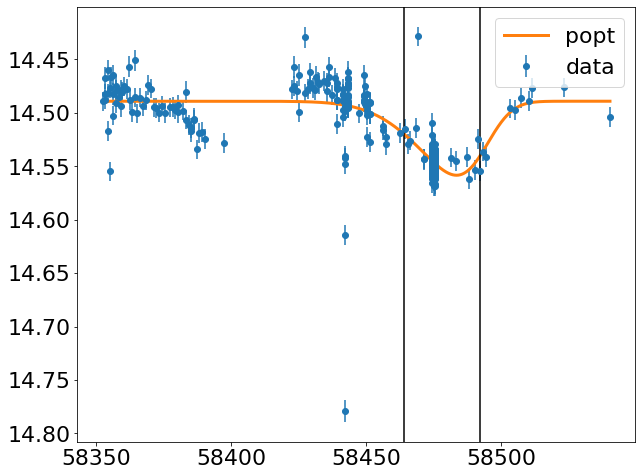


    id               = 178440179565632477
    dip.significance = 16.118515014648438
    fit_r.skew       = -2.4444868564605713
    


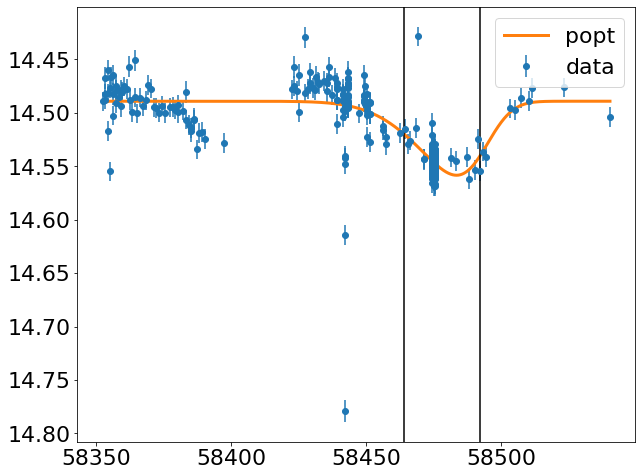


    id               = 126141566241591853
    dip.significance = 16.08588409423828
    fit_r.skew       = 5.036335468292236
    


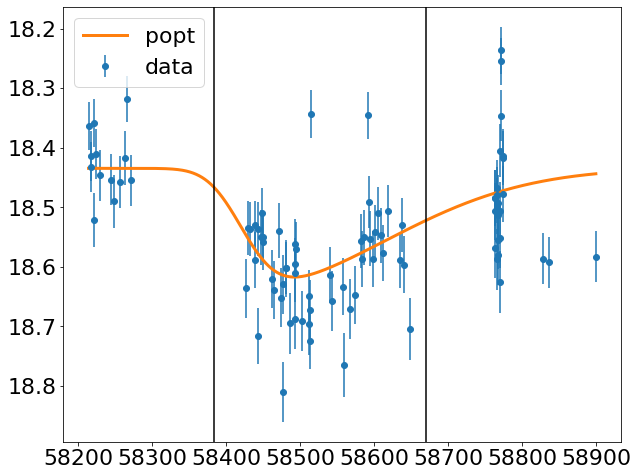


    id               = 126141566241591853
    dip.significance = 16.08588409423828
    fit_r.skew       = 5.036335468292236
    


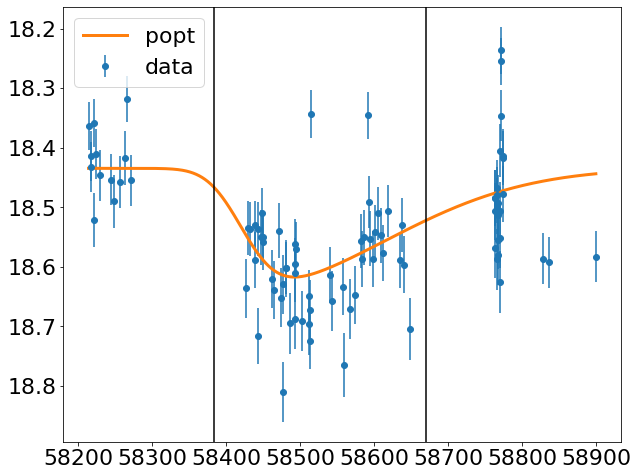


    id               = 118120762399214803
    dip.significance = 16.009801864624023
    fit_r.skew       = -2.554304361343384
    


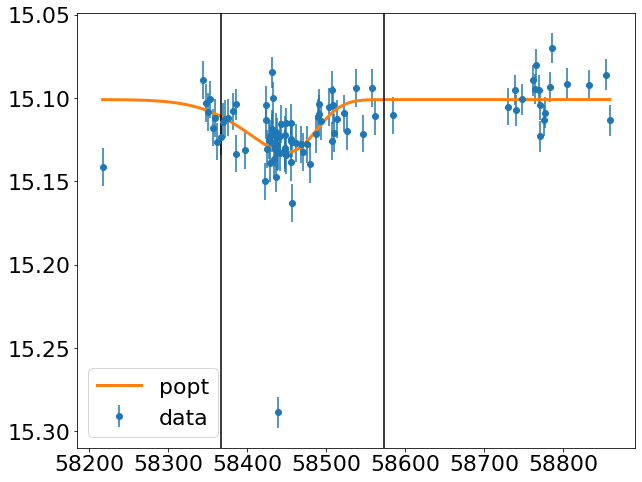


    id               = 106052859876836690
    dip.significance = 15.960809707641602
    fit_r.skew       = -6.969239234924316
    


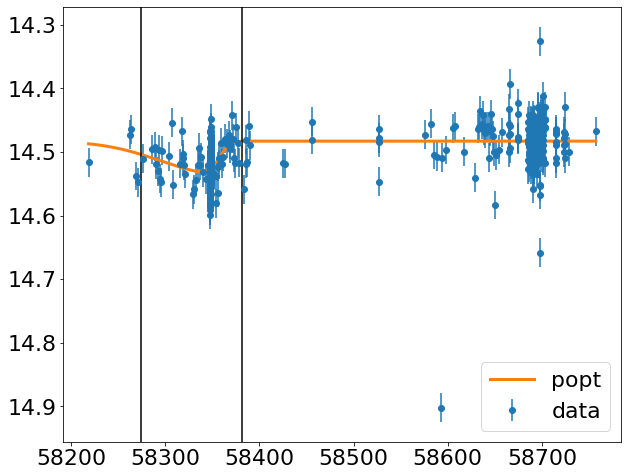


    id               = 120772803241632375
    dip.significance = 15.936223983764648
    fit_r.skew       = 2.048198938369751
    


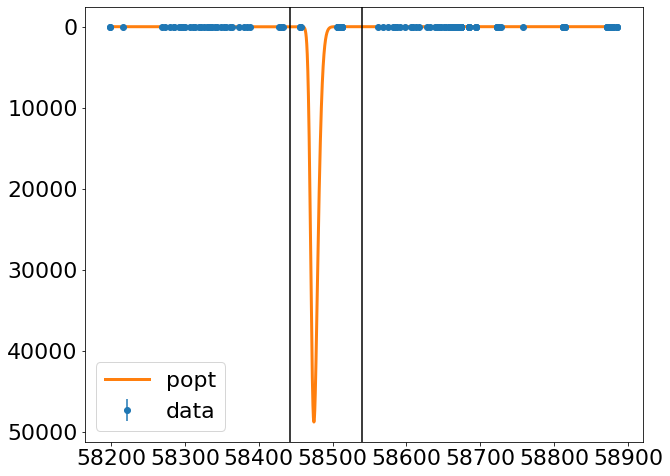


    id               = 119412872899756567
    dip.significance = 15.90283489227295
    fit_r.skew       = 18.033348083496094
    


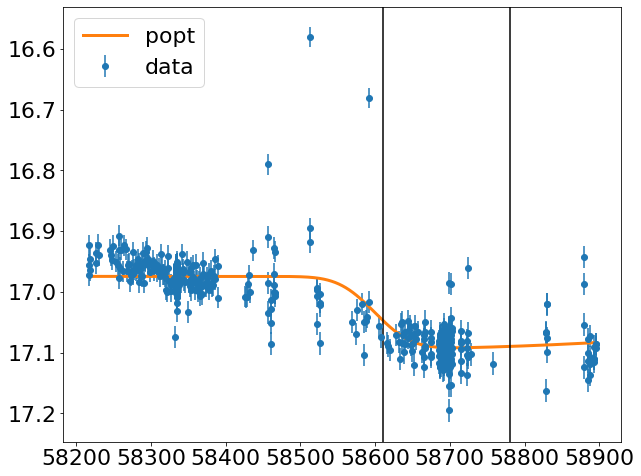

In [18]:
nplot = 0
total = 100
for lc in fits_to_show_window_error_in_memory:
    if nplot == total:
        break
    x = lc['window_r']['x']
    nplot += 1
        
    y = lc['window_r']['y']
    yerr = lc['window_r']['yerr']
    fit = lc['fit_r']
    plot_fit_result(
        x, y, yerr, 
        fit, skew_normal
    )

    dip = lc['dip']
    
    plt.axvline(dip['start_mjd'], color="k", label="start")
    plt.axvline(dip['end_mjd'], color="k", label="end")
    print("""
    id               = {}
    dip.significance = {}
    fit_r.skew       = {}
    """.format(
        lc['ps1_objid'],
        dip['significance'],
        fit['popt'][0]
    ))
    
    plt.gca().invert_yaxis()
    plt.show()